# Charcoal results when using the GTDB rs207 representatives database to decontaminate all of GTDB rs207

In [1]:
setwd("..")

In [3]:
library(dplyr, warn.conflicts = F)
library(readr)
library(tidyr)
library(purrr)
library(broom)
library(ggplot2)
library(ggpubr)
source("~/github/2022-microberna/scripts/utils.R")

In [4]:
# change default figure size
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res = 300)
# disable scientific notation (for plot axes)
options(scipen = 999)

## Obtain and read in GTDB rs207 metadata

In [5]:
destfile <- "inputs/gtdb-rs207/bac120_metadata_rs207.tar.gz"
url <- "https://data.gtdb.ecogenomic.org/releases/release207/207.0/bac120_metadata_r207.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb-rs207/bac120_metadata_r207.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb-rs207")
}

destfile <- "inputs/gtdb-rs207/ar53_metadata_rs207.tar.gz"
url <- "https://data.gtdb.ecogenomic.org/releases/release207/207.0/ar53_metadata_r207.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb-r207/ar53_metadata_r207.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb-rs207")
}

In [6]:
gtdb_metadata <- read_tsv("inputs/gtdb-rs207/bac120_metadata_r207.tsv", show_col_types = FALSE) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession))

gtdb_metadata <- read_tsv("inputs/gtdb-rs207/ar53_metadata_r207.tsv", show_col_types = FALSE) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession)) %>%
  bind_rows(gtdb_metadata)

Warning message:
“One or more parsing issues, see `problems()` for details”


## Read in charcoal results

In [7]:
# read in charcoal stage1 results
charcoal <- Sys.glob("outputs/gtdb_rs207_charcoal*_reps/stage1_hitlist.csv") %>%
  map_dfr(read_csv, show_col_types = F) %>%                # read in charcoal stage1 results
  mutate(genome = gsub("_genomic.fna.gz", "", genome)) %>% # edit genome to just accession
  filter(genome %in% gtdb_metadata$accession)              # filter to only genomes in rs207; some RefSeq changed to GenBank

In [8]:
dim(charcoal)

[1] 317541     14

In [9]:
# combine with GTDB metadata
gtdb_metadata <- gtdb_metadata %>%
  mutate(order_lineage = paste(sep = ";", domain, phylum, class, order))

combined <- left_join(charcoal, gtdb_metadata, by = c("genome" = "accession")) %>%
  mutate(lineages_match = ifelse(lineage == order_lineage, T, F),
         charcoal_pct_contamination_order = (order_bad_bp/genome_size)*100,
         charcoal_pct_contamination_family = (family_bad_bp/genome_size)*100,
         charcoal_pct_contamination_genus = (genus_bad_bp/genome_size)*100,
         contaminated_at_filter_rank = ifelse(order_bad_bp > 0, T, F),
         contaminated_with_checkm = ifelse(checkm_contamination > 0, T, F),
         contaminated_at_filter_rank = factor(contaminated_at_filter_rank,
                                              levels = c(TRUE, FALSE)),
         contaminated_at_family = ifelse(family_bad_bp > 0, T, F)) %>%
  filter(!is.na(ncbi_database)) # filter out genomes that switched from GenBank to RefSeq

## how many genomes were contaminated?

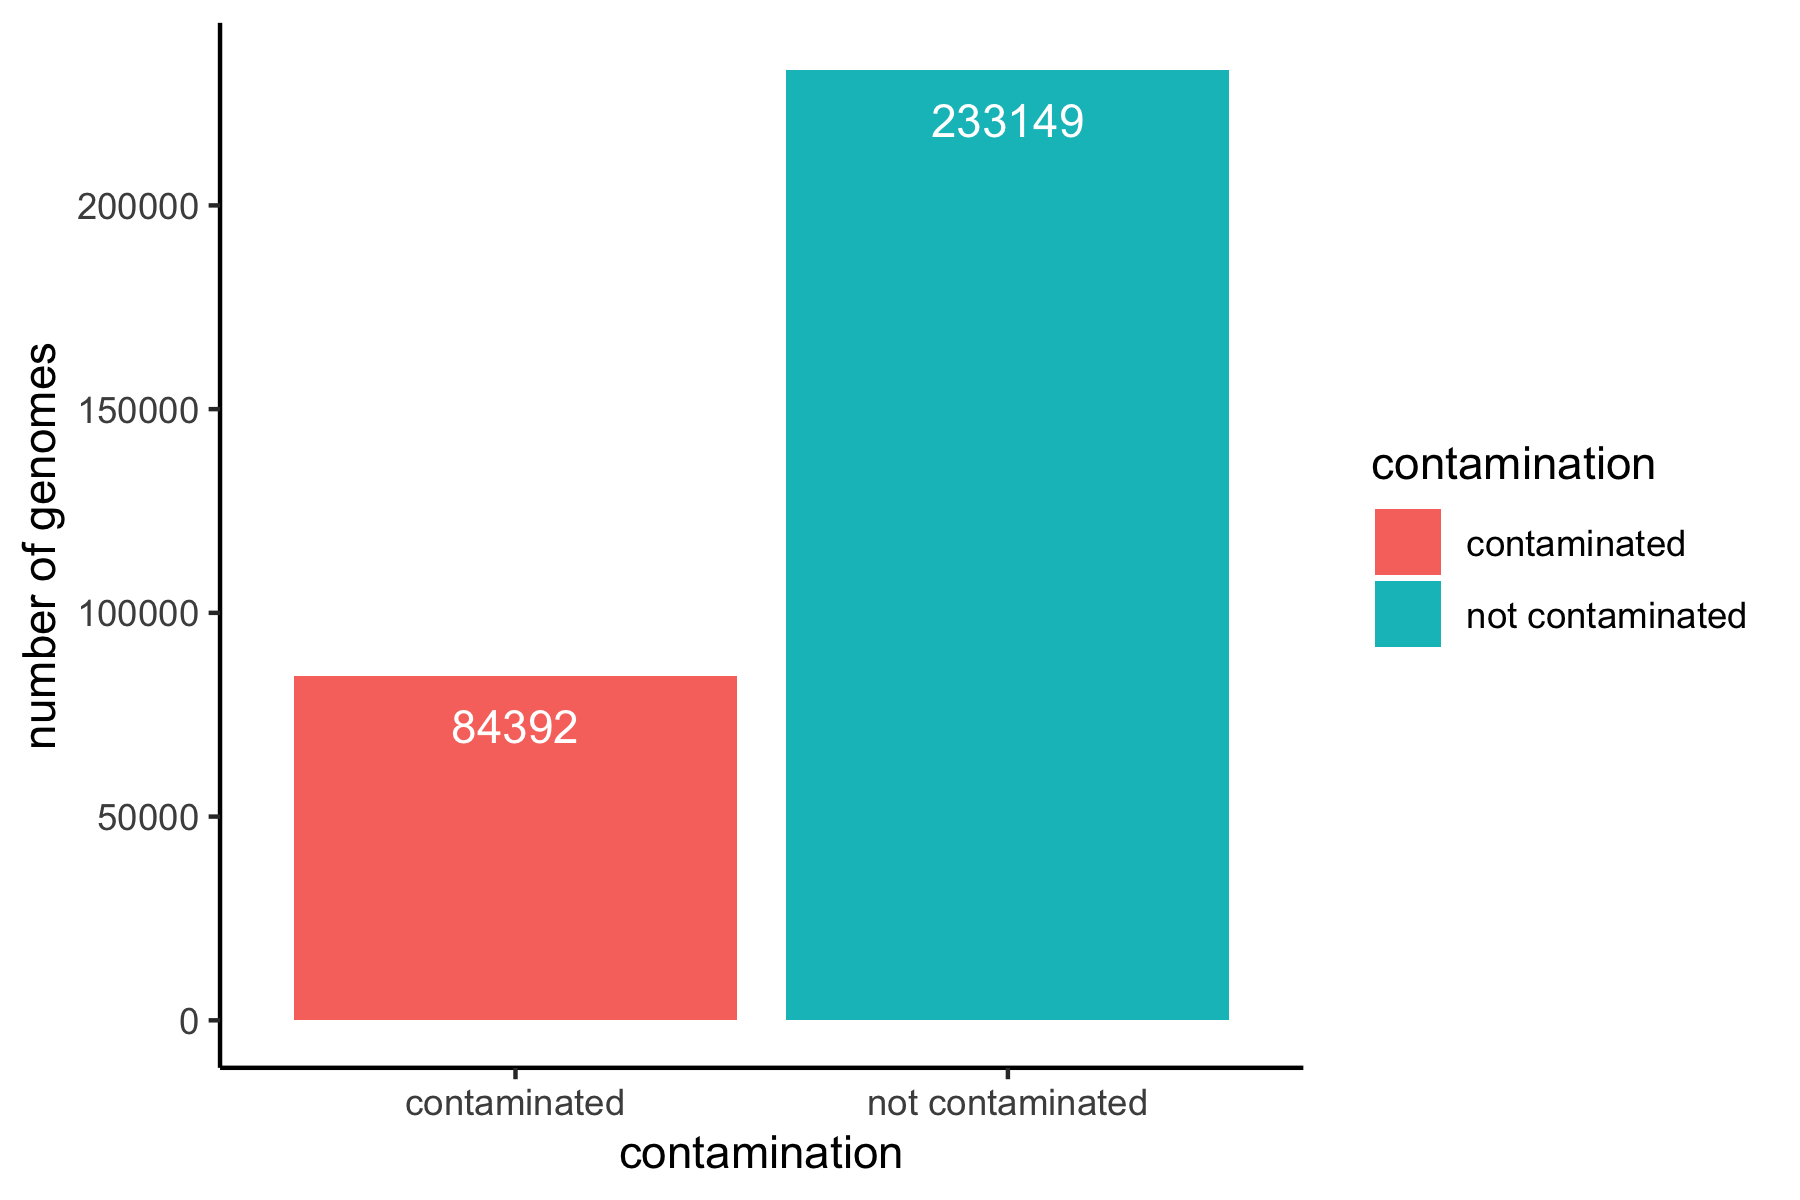

In [10]:
num_contam_plt <- ggplot(combined, aes(x = contaminated_at_filter_rank, label = stat(count), fill = contaminated_at_filter_rank)) +
  geom_bar() +
  geom_text(stat = 'count', vjust = 2, color = "white") +
  theme_classic() +
  labs(y = "number of genomes", x = "contamination", fill = "contamination") +
  scale_x_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) +
  scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated"))

num_contam_plt

In [11]:
84392/(84392+233149)

[1] 0.2657673

## how many refseq genomes were contaminated?

Tells us that "not contaminated" is associated with RefSeq and "contaminated" is associated with GenBank

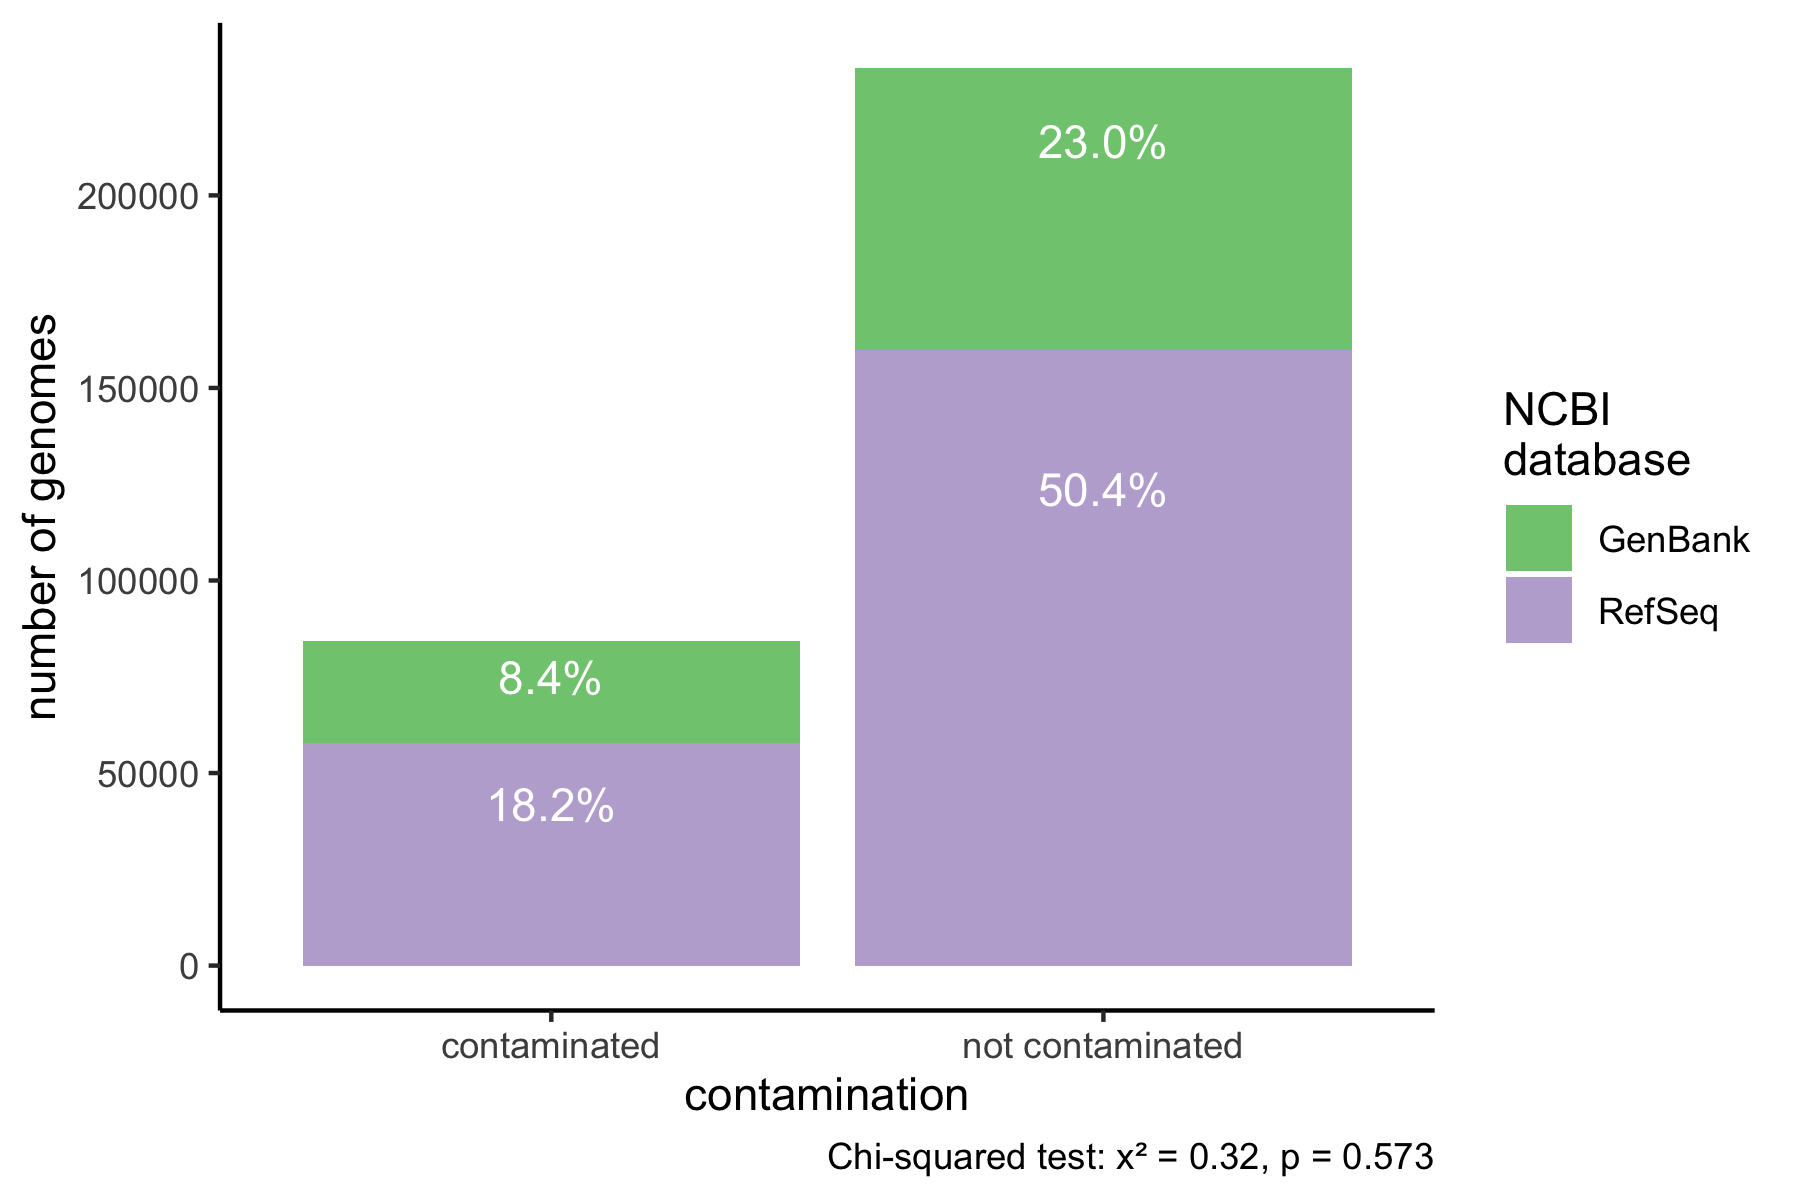

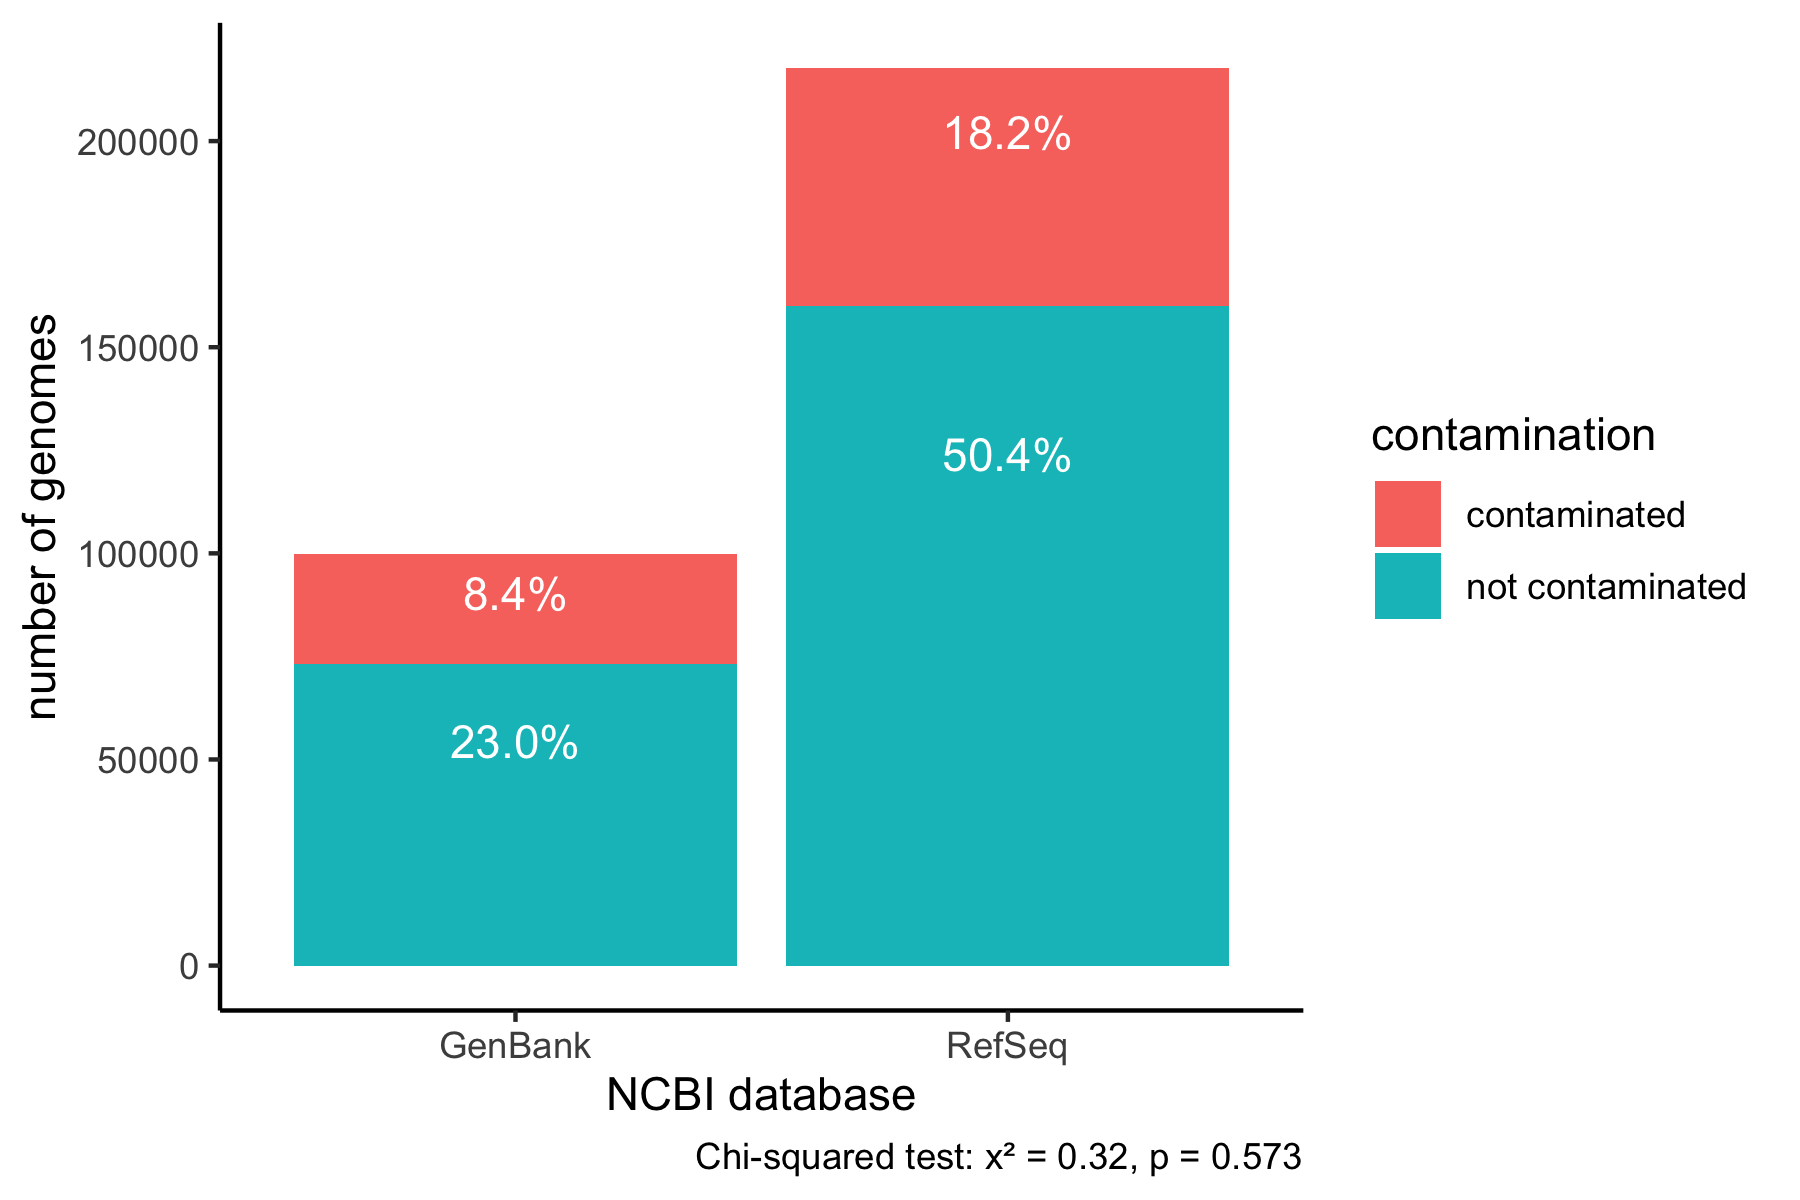

In [12]:
chi_sq_ncbi_db <- combined %>% 
  group_by(contaminated_at_filter_rank) %>% 
  ungroup %>%
  summarise(pval = chisq.test(contaminated_at_filter_rank, ncbi_database)$p.value,
            x_squared = chisq.test(contaminated_at_filter_rank, ncbi_database)$statistic)

num_contam_db_plt1 <- ggplot(combined, aes(x = contaminated_at_filter_rank, fill = ncbi_database,
                     label = scales::percent(prop.table(stat(count))))) +
  geom_bar() +
  geom_text(stat = 'count', color = "white", vjust = 1,
            position = position_stack(.8)) +
  theme_classic() +
  labs(y = "number of genomes", x = "contamination", fill = "NCBI\ndatabase",
    caption = paste0("Chi-squared test: x² = ", 
                        round(chi_sq_ncbi_db$x_squared, digits =2), 
                        ", p = ", round(chi_sq_ncbi_db$pval,digits = 3))) +
  scale_x_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) +
  scale_fill_brewer(palette = "Accent")


num_contam_db_plt2 <- ggplot(combined, aes(x = ncbi_database, fill = contaminated_at_filter_rank,
                     label = scales::percent(prop.table(stat(count))))) +
  geom_bar() +
  geom_text(stat = 'count', color = "white", vjust = 1,
            position = position_stack(.8)) +
  theme_classic() +
  labs(y = "number of genomes", x = "NCBI database", fill = "contamination",
    caption = paste0("Chi-squared test: x² = ", 
                        round(chi_sq_ncbi_db$x_squared, digits =2), 
                        ", p = ", round(chi_sq_ncbi_db$pval,digits = 3))) +
  scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) 

num_contam_db_plt1
num_contam_db_plt2

In [13]:
table(combined$ncbi_database)


GenBank  RefSeq 
  99743  217798 

## How many representative genomes were contaminated?

Tells us that "not contaminated" is associated with "GTDB representative" and that "contaminated" is associated with "not GTDB representative"

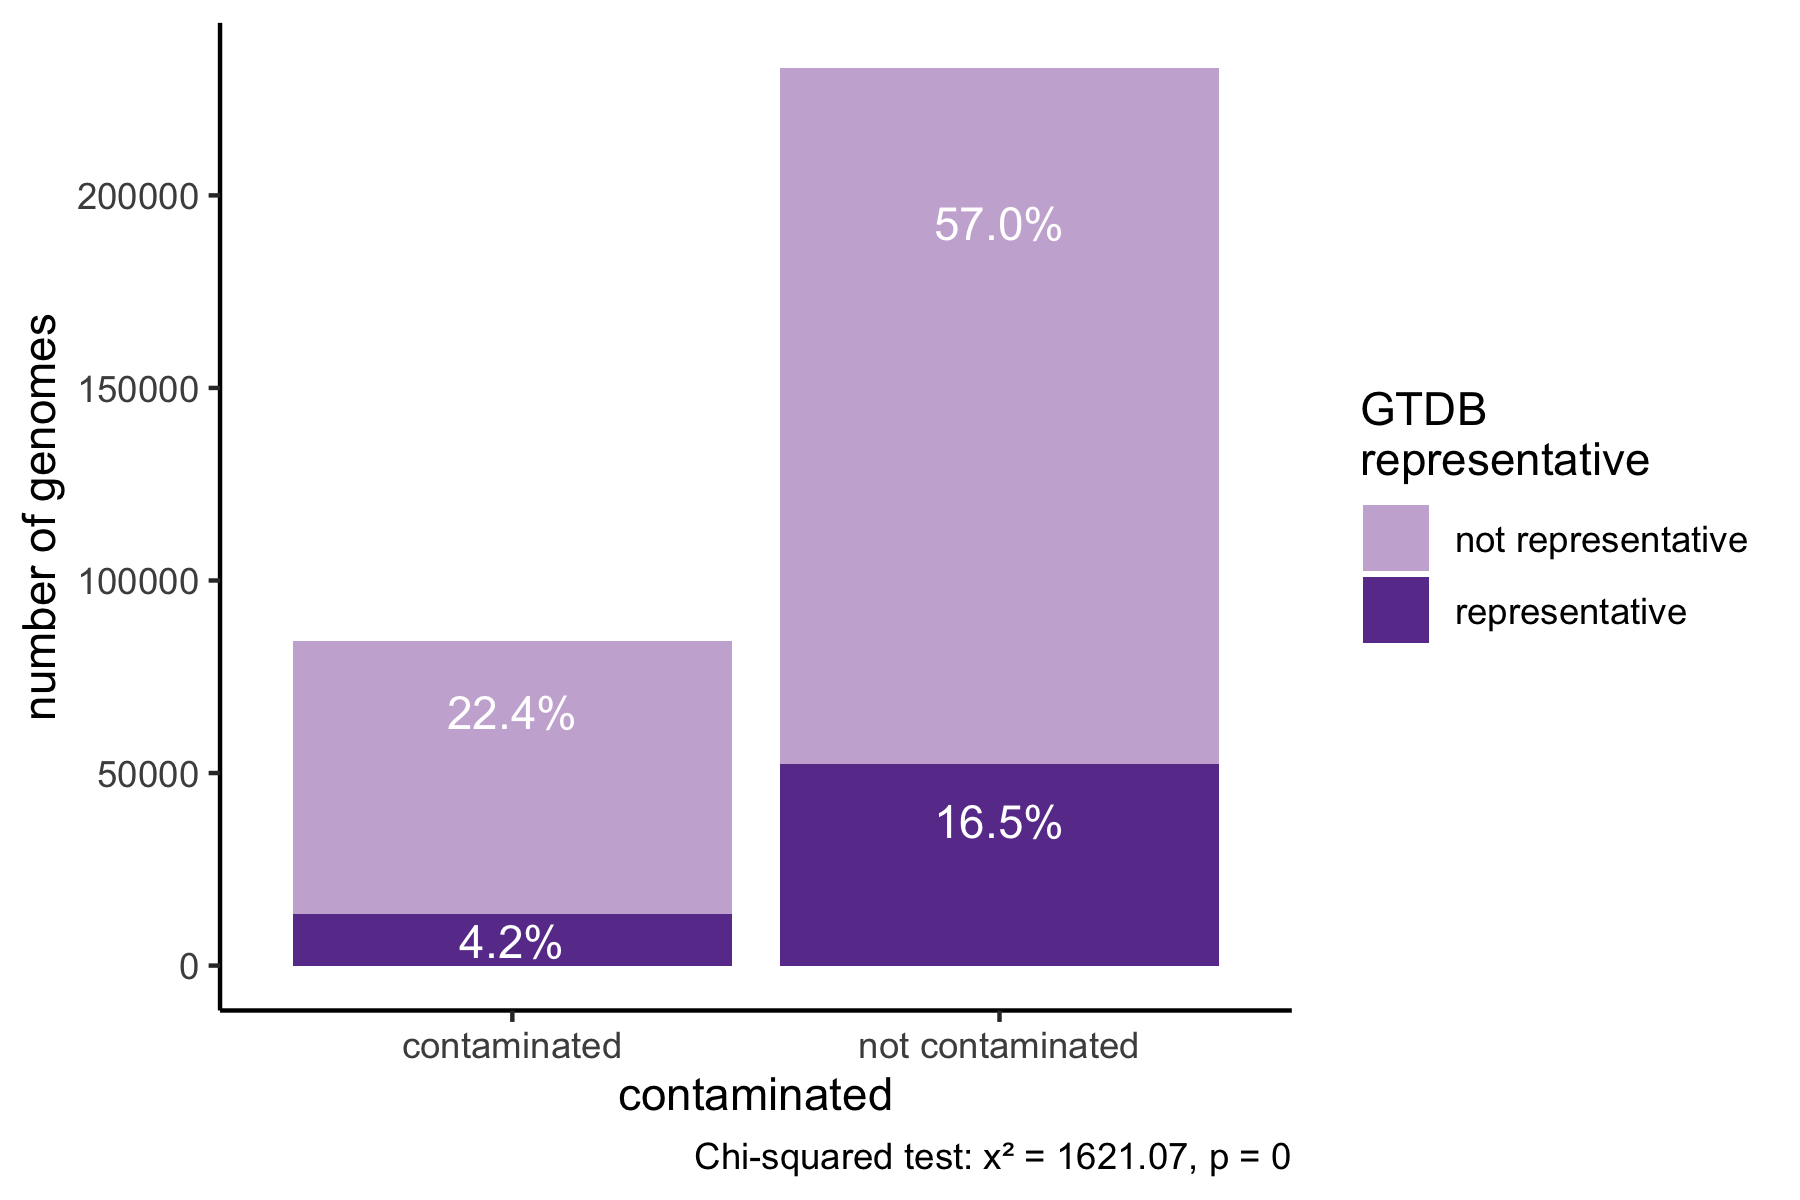

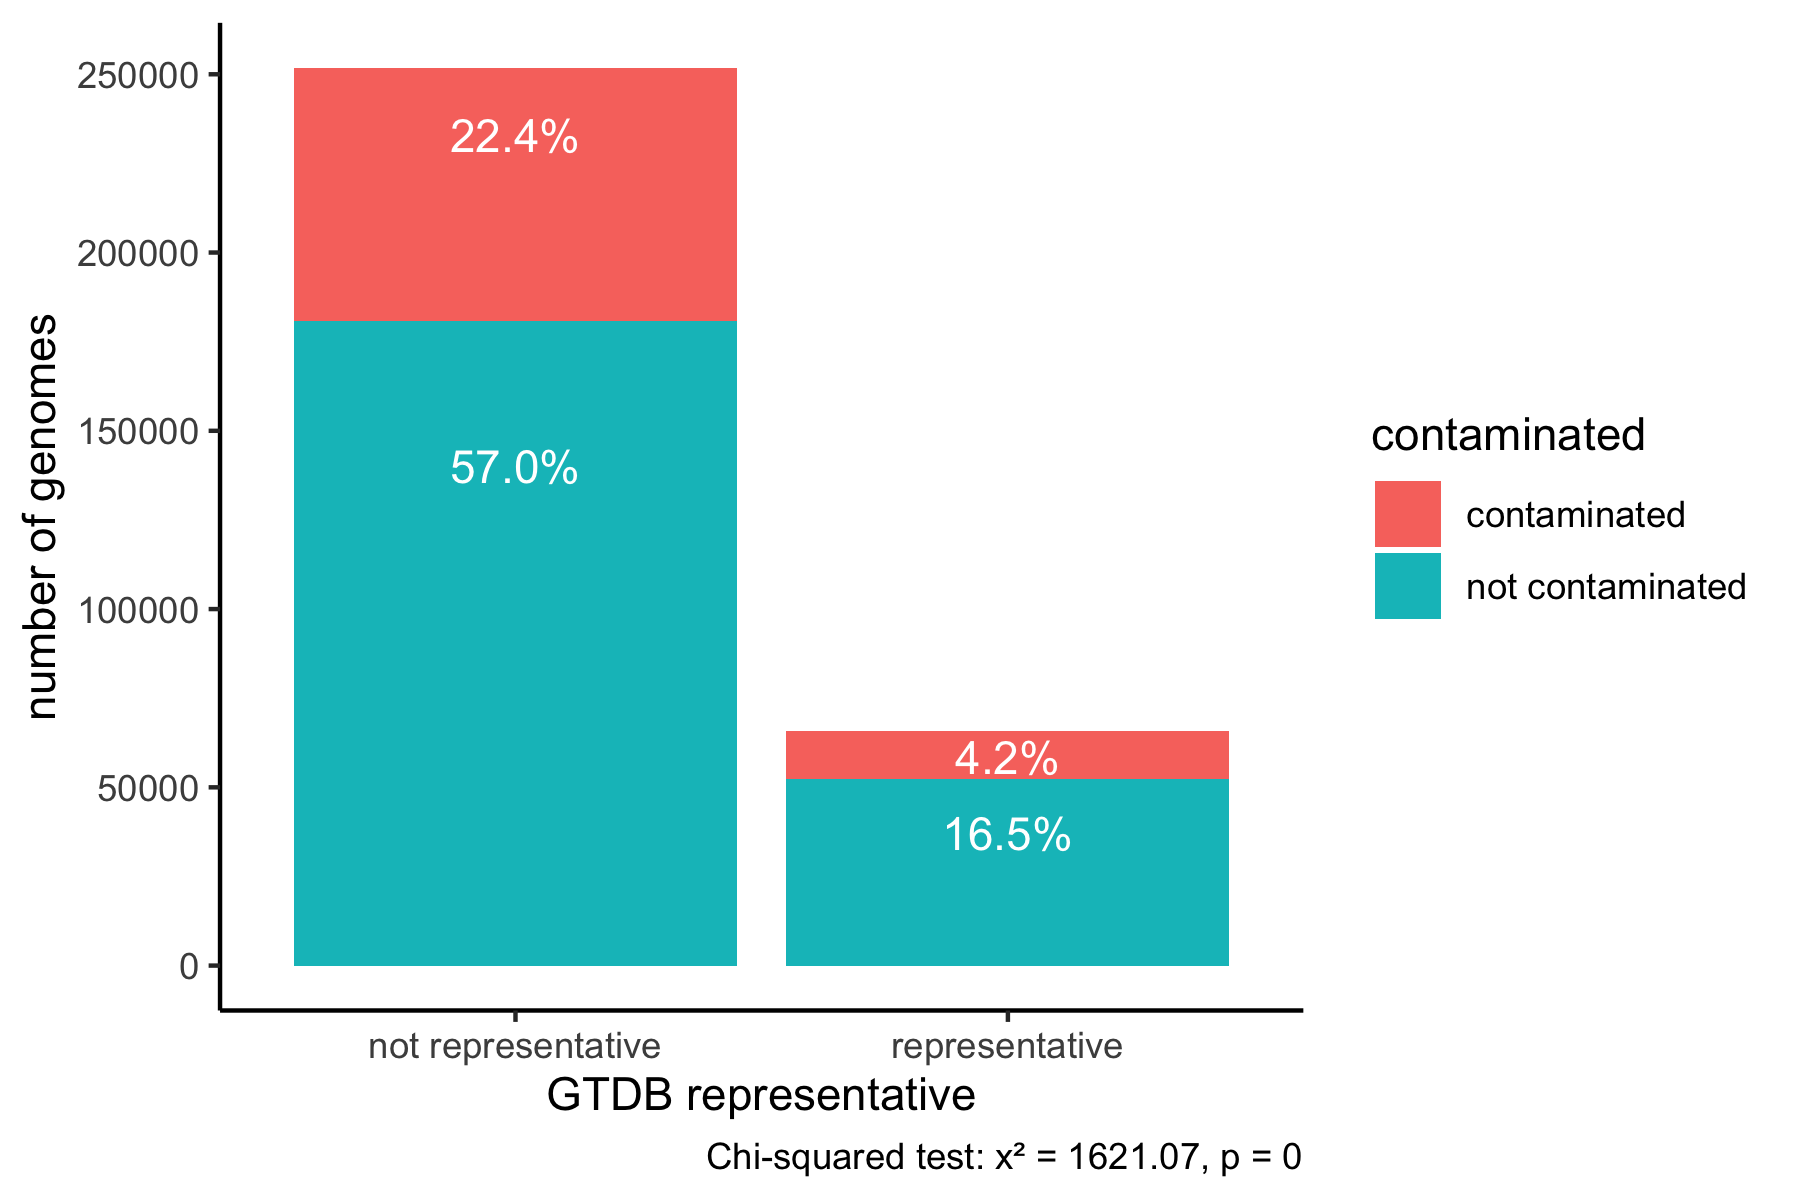

In [14]:
chi_sq_gtdb_rep <- combined %>% 
  group_by(contaminated_at_filter_rank) %>% 
  ungroup %>%
  summarise(pval = chisq.test(contaminated_at_filter_rank, gtdb_representative)$p.value,
            x_squared = chisq.test(contaminated_at_filter_rank, gtdb_representative)$statistic)

num_contam_reps_plt1 <- ggplot(combined, aes(x = contaminated_at_filter_rank, fill = gtdb_representative,
                     label = scales::percent(prop.table(stat(count))))) +
  geom_bar() + 
  theme_classic() +
  geom_text(stat = 'count', color = "white", vjust = 1,
            position = position_stack(.8)) +
  labs(y = "number of genomes", x = "contaminated", fill = "GTDB\nrepresentative",
       caption = paste0("Chi-squared test: x² = ", 
                        round(chi_sq_gtdb_rep$x_squared, digits =2), 
                        ", p = ", round(chi_sq_gtdb_rep$pval,digits = 3))) +
  scale_x_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) + 
  scale_fill_manual(labels = c("FALSE" = "not representative", "TRUE"="representative"),
                    values = c("#CAB2D6", "#6A3D9A")) 

num_contam_reps_plt2 <- ggplot(combined, aes(x = gtdb_representative, fill = contaminated_at_filter_rank,
                     label = scales::percent(prop.table(stat(count))))) +
  geom_bar() + 
  theme_classic() +
  geom_text(stat = 'count', color = "white", vjust = 1,
            position = position_stack(.8)) +
  labs(y = "number of genomes", fill = "contaminated", x = "GTDB representative",
       caption = paste0("Chi-squared test: x² = ", 
                        round(chi_sq_gtdb_rep$x_squared, digits =2), 
                        ", p = ", round(chi_sq_gtdb_rep$pval,digits = 3))) +
  scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) + 
  scale_x_discrete(labels = c("FALSE" = "not representative", "TRUE"="representative")) 

num_contam_reps_plt1
num_contam_reps_plt2

### are genomes with longer contigs less likely to be contaminated?

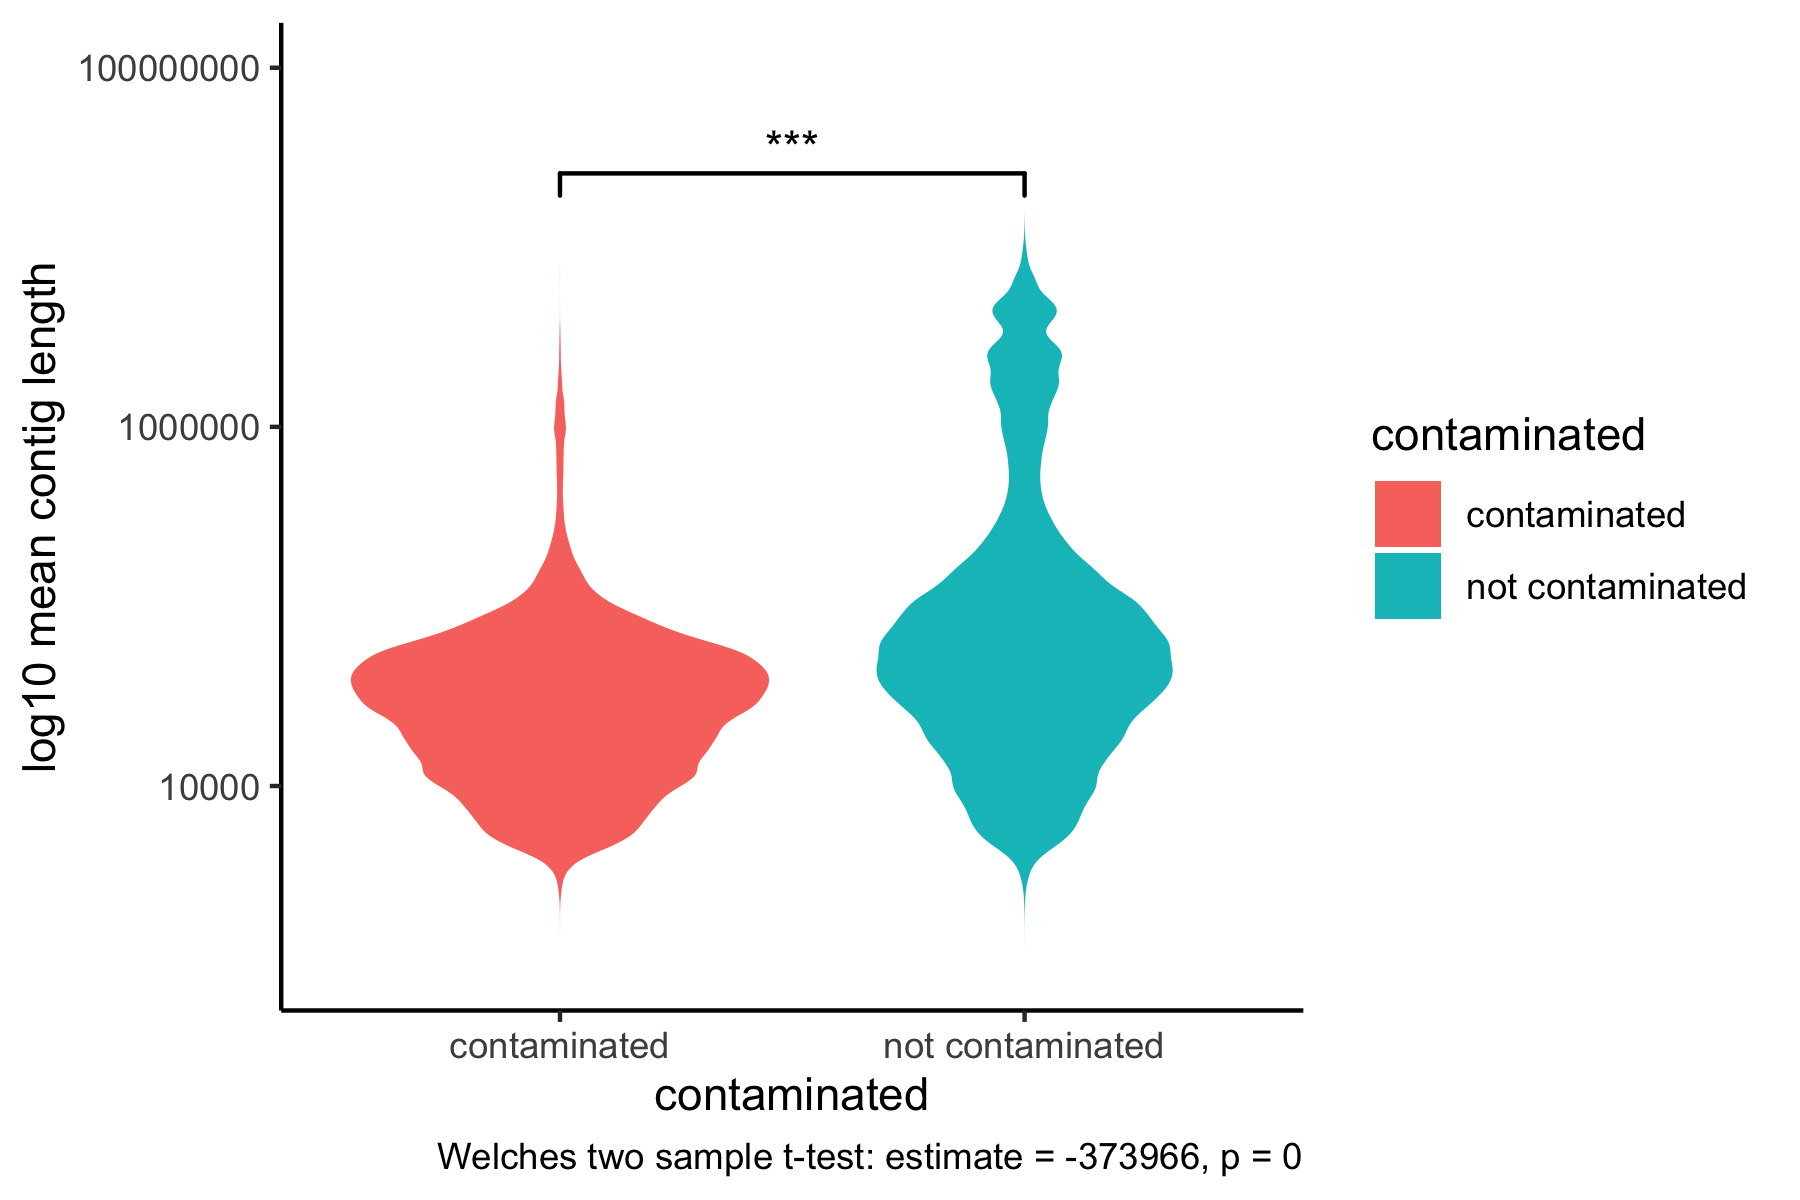

In [15]:
ttest_len_contigs <- combined %>%
  do(tidy(t.test(mean_contig_length ~ contaminated_at_filter_rank, data = .)))

len_contigs_contam_plt <- ggplot(combined, aes(x = contaminated_at_filter_rank, y = mean_contig_length, 
                     fill = contaminated_at_filter_rank)) +
  #geom_boxplot(outlier.alpha = .05) +
  geom_violin(color = NA) +
  theme_classic() +
  scale_y_log10(limits = c(1000, 100000000)) +
  geom_signif(comparisons = list(c('TRUE', 'FALSE')), map_signif_level=TRUE) +
  labs(x = "contaminated", y = "log10 mean contig length", fill = "contaminated",
       caption = paste0("Welches two sample t-test: estimate = ", 
                        round(ttest_len_contigs$estimate, digits = 0), 
                        ", p = ", round(ttest_len_contigs$p.value, digits = 3))) +
  scale_x_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) +
  scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated"))

len_contigs_contam_plt

In [16]:
combined %>%
  group_by(contaminated_at_filter_rank) %>%
  summarize(mean_of_mean_contig_length = mean(mean_contig_length))

contaminated_at_filter_rank,mean_of_mean_contig_length
<fct>,<dbl>
TRUE,52049.92
FALSE,426015.92


In [17]:
combined %>%
  do(tidy(t.test(mean_contig_length ~ contaminated_at_filter_rank, data = .)))

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-373966,52049.92,426015.9,-159.4214,0,256005.3,-378563.6,-369368.4,Welch Two Sample t-test,two.sided


### are genomes with higher GC percentage less likely to be contaminated?

In [18]:
colnames(combined)

[1] "genome"                            "filter_at"                        
  [3] "override_filter_at"                "total_bad_bp"                     
  [5] "superkingdom_bad_bp"               "phylum_bad_bp"                    
  [7] "class_bad_bp"                      "order_bad_bp"                     
  [9] "family_bad_bp"                     "genus_bad_bp"                     
 [11] "f_ident"                           "f_major"                          
 [13] "lineage"                           "comment"                          
 [15] "ambiguous_bases"                   "checkm_completeness"              
 [17] "checkm_contamination"              "checkm_marker_count"              
 [19] "checkm_marker_lineage"             "checkm_marker_set_count"          
 [21] "checkm_strain_heterogeneity"       "coding_bases"                     
 [23] "coding_density"                    "contig_count"                     
 [25] "gc_count"                          "gc_percentage"                    
 [27] "genome_size"                       "gtdb_genome_representative"       
 [29] "gtdb_representative"               "domain"                           
 [31] "phylum"                            "class"                            
 [33] "order"                             "family"                           
 [35] "genus"                             "species"                          
 [37] "gtdb_type_designation"             "gtdb_type_designation_sources"    
 [39] "gtdb_type_species_of_genus"        "l50_contigs"                      
 [41] "l50_scaffolds"                     "longest_contig"                   
 [43] "longest_scaffold"                  "lsu_23s_contig_len"               
 [45] "lsu_23s_count"                     "lsu_23s_length"                   
 [47] "lsu_23s_query_id"                  "lsu_5s_contig_len"                
 [49] "lsu_5s_count"                      "lsu_5s_length"                    
 [51] "lsu_5s_query_id"                   "lsu_silva_23s_blast_align_len"    
 [53] "lsu_silva_23s_blast_bitscore"      "lsu_silva_23s_blast_evalue"       
 [55] "lsu_silva_23s_blast_perc_identity" "lsu_silva_23s_blast_subject_id"   
 [57] "lsu_silva_23s_taxonomy"            "mean_contig_length"               
 [59] "mean_scaffold_length"              "mimag_high_quality"               
 [61] "mimag_low_quality"                 "mimag_medium_quality"             
 [63] "n50_contigs"                       "n50_scaffolds"                    
 [65] "ncbi_assembly_level"               "ncbi_assembly_name"               
 [67] "ncbi_assembly_type"                "ncbi_bioproject"                  
 [69] "ncbi_biosample"                    "ncbi_contig_count"                
 [71] "ncbi_contig_n50"                   "ncbi_country"                     
 [73] "ncbi_date"                         "ncbi_genbank_assembly_accession"  
 [75] "ncbi_genome_category"              "ncbi_genome_representation"       
 [77] "ncbi_isolate"                      "ncbi_isolation_source"            
 [79] "ncbi_lat_lon"                      "ncbi_molecule_count"              
 [81] "ncbi_ncrna_count"                  "ncbi_organism_name"               
 [83] "ncbi_protein_count"                "ncbi_refseq_category"             
 [85] "ncbi_rrna_count"                   "ncbi_scaffold_count"              
 [87] "ncbi_scaffold_l50"                 "ncbi_scaffold_n50"                
 [89] "ncbi_scaffold_n75"                 "ncbi_scaffold_n90"                
 [91] "ncbi_seq_rel_date"                 "ncbi_spanned_gaps"                
 [93] "ncbi_species_taxid"                "ncbi_ssu_count"                   
 [95] "ncbi_strain_identifiers"           "ncbi_submitter"                   
 [97] "ncbi_taxid"                        "ncbi_taxonomy"                    
 [99] "ncbi_taxonomy_unfiltered"          "ncbi_total_gap_length"            
[101] "ncbi_total_length"                 "ncbi_translation_table"           
[103] "ncbi_trna_count" 

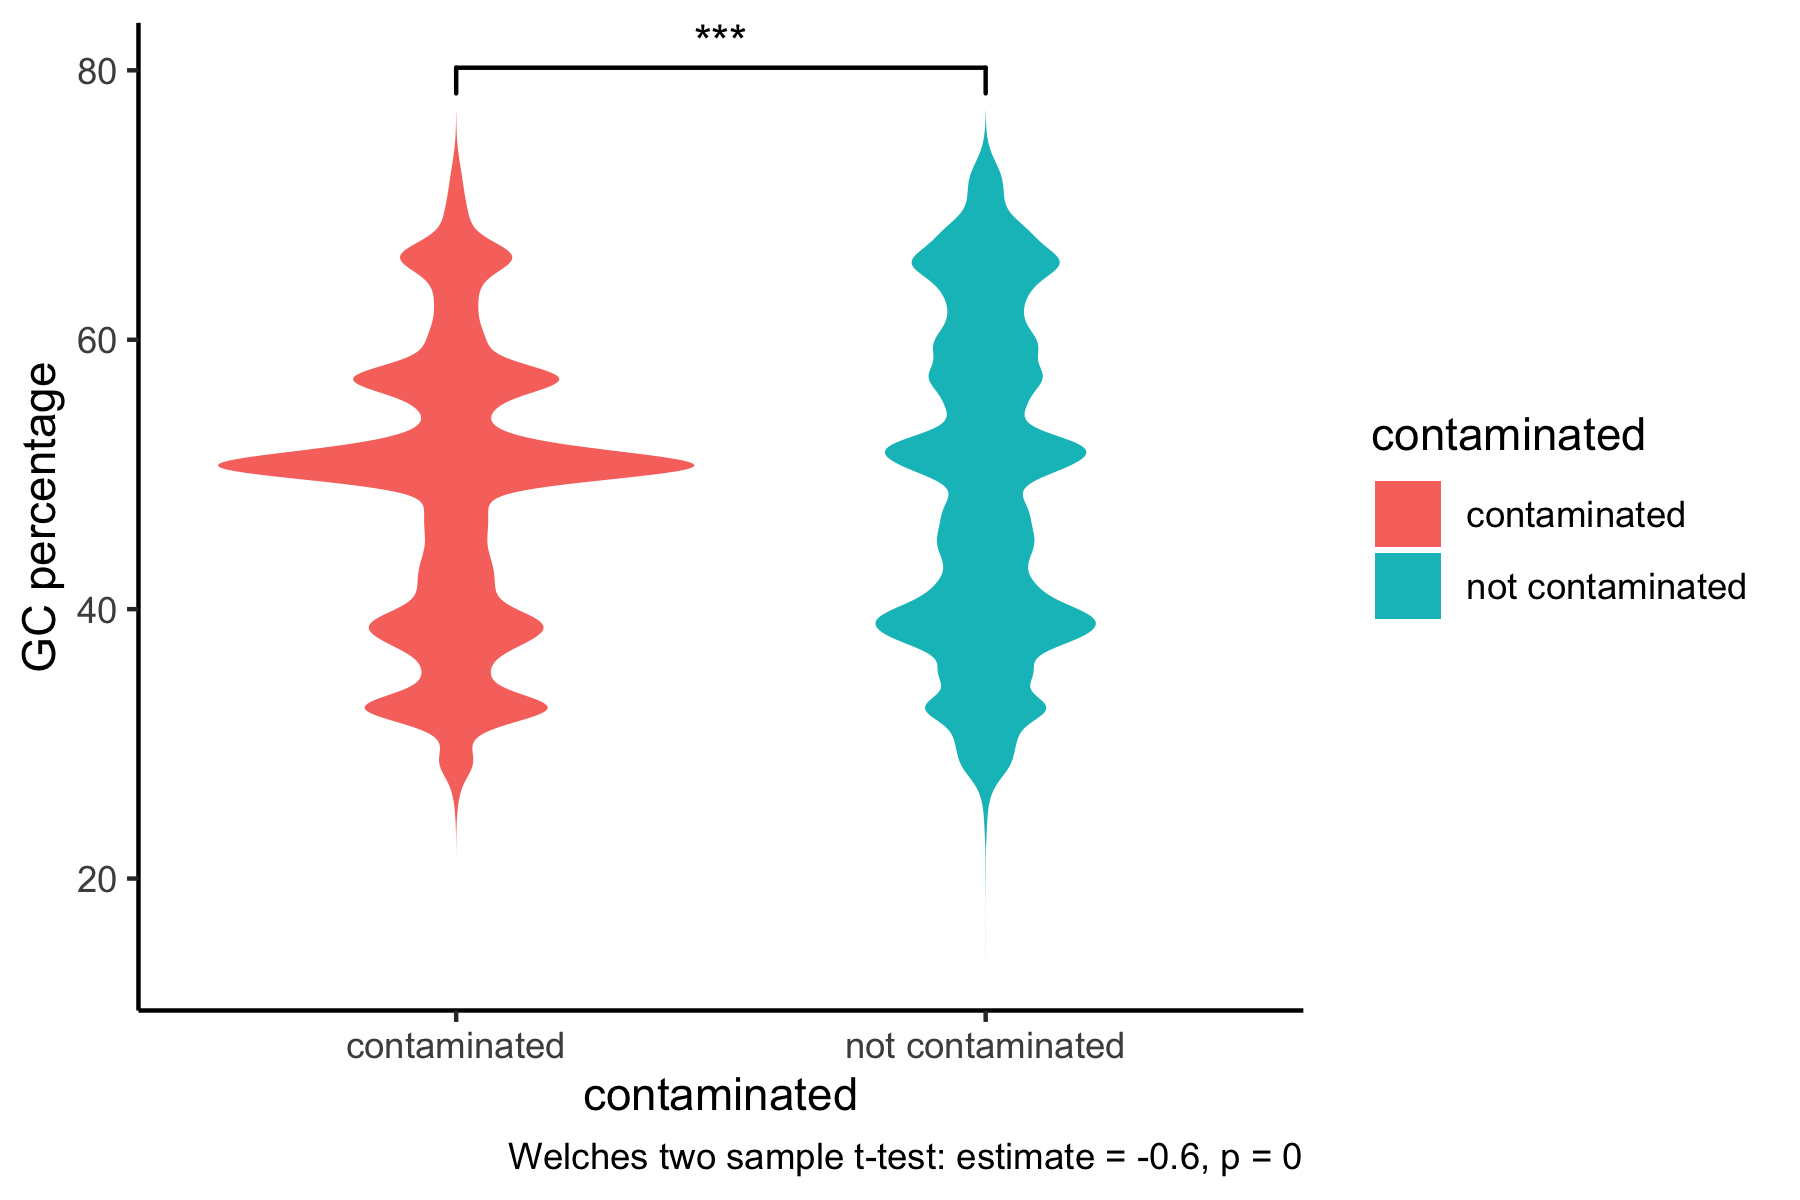

In [19]:
ttest_gc_pct <- combined %>%
  do(tidy(t.test(gc_percentage ~ contaminated_at_filter_rank, data = .)))

gc_pct_contam_plt <- ggplot(combined, aes(x = contaminated_at_filter_rank, y = gc_percentage, 
                     fill = contaminated_at_filter_rank)) +
  #geom_boxplot(outlier.alpha = .05) +
  geom_violin(color = NA) +
  theme_classic() +
  geom_signif(comparisons = list(c('TRUE', 'FALSE')), map_signif_level=TRUE) +
  labs(x = "contaminated", y = "GC percentage", fill = "contaminated",
       caption = paste0("Welches two sample t-test: estimate = ", 
                        round(ttest_gc_pct$estimate, digits = 1), 
                        ", p = ", round(ttest_gc_pct$p.value, digits = 3))) +
  scale_x_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) +
  scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated"))

gc_pct_contam_plt

In [20]:
combined %>%
  group_by(contaminated_at_filter_rank) %>%
  summarize(mean_of_gc_percentage = mean(gc_percentage))

contaminated_at_filter_rank,mean_of_gc_percentage
<fct>,<dbl>
TRUE,48.55709
FALSE,49.11773


### are genomes with higher tRNA estimates more likely to be contaminated?

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 2 rows containing non-finite values (stat_signif).”


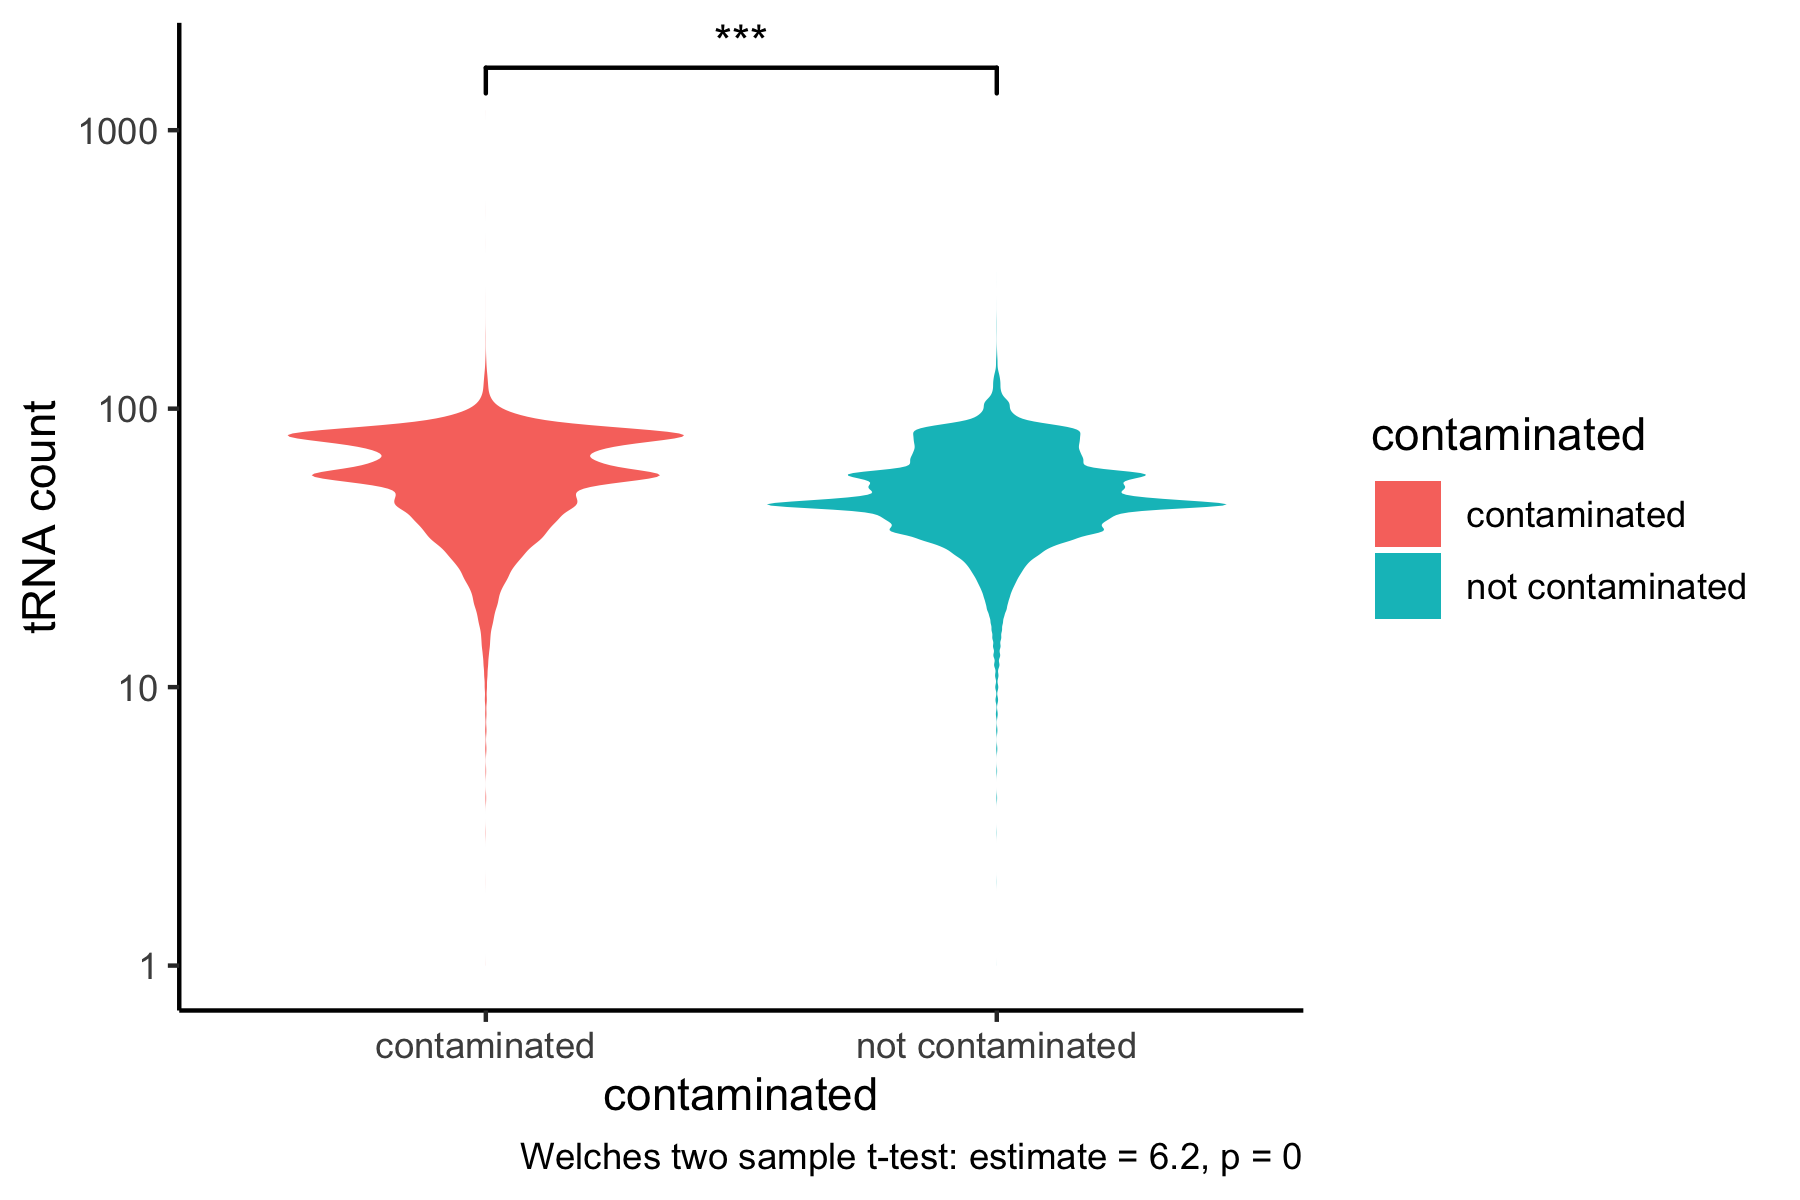

In [21]:
ttest_trna_count <- combined %>%
  do(tidy(t.test(trna_count ~ contaminated_at_filter_rank, data = .)))

trna_count_contam_plt <- ggplot(combined, aes(x = contaminated_at_filter_rank, y = trna_count, 
                     fill = contaminated_at_filter_rank)) +
  #geom_boxplot(outlier.alpha = .05) +
  geom_violin(color = NA) +
  theme_classic() +
  scale_y_log10() +
  geom_signif(comparisons = list(c('TRUE', 'FALSE')), map_signif_level=TRUE) +
  labs(x = "contaminated", y = "tRNA count", fill = "contaminated",
       caption = paste0("Welches two sample t-test: estimate = ", 
                        round(ttest_trna_count$estimate, digits = 1), 
                        ", p = ", round(ttest_trna_count$p.value, digits = 3))) +
  scale_x_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) +
  scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated"))

trna_count_contam_plt

In [22]:
combined %>%
  group_by(contaminated_at_filter_rank) %>%
  summarize(mean_of_trna_count = mean(trna_count))

contaminated_at_filter_rank,mean_of_trna_count
<fct>,<dbl>
TRUE,58.03851
FALSE,51.88168


### are genomes with higher coding density more likely to be contaminated?

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 2 rows containing non-finite values (stat_signif).”


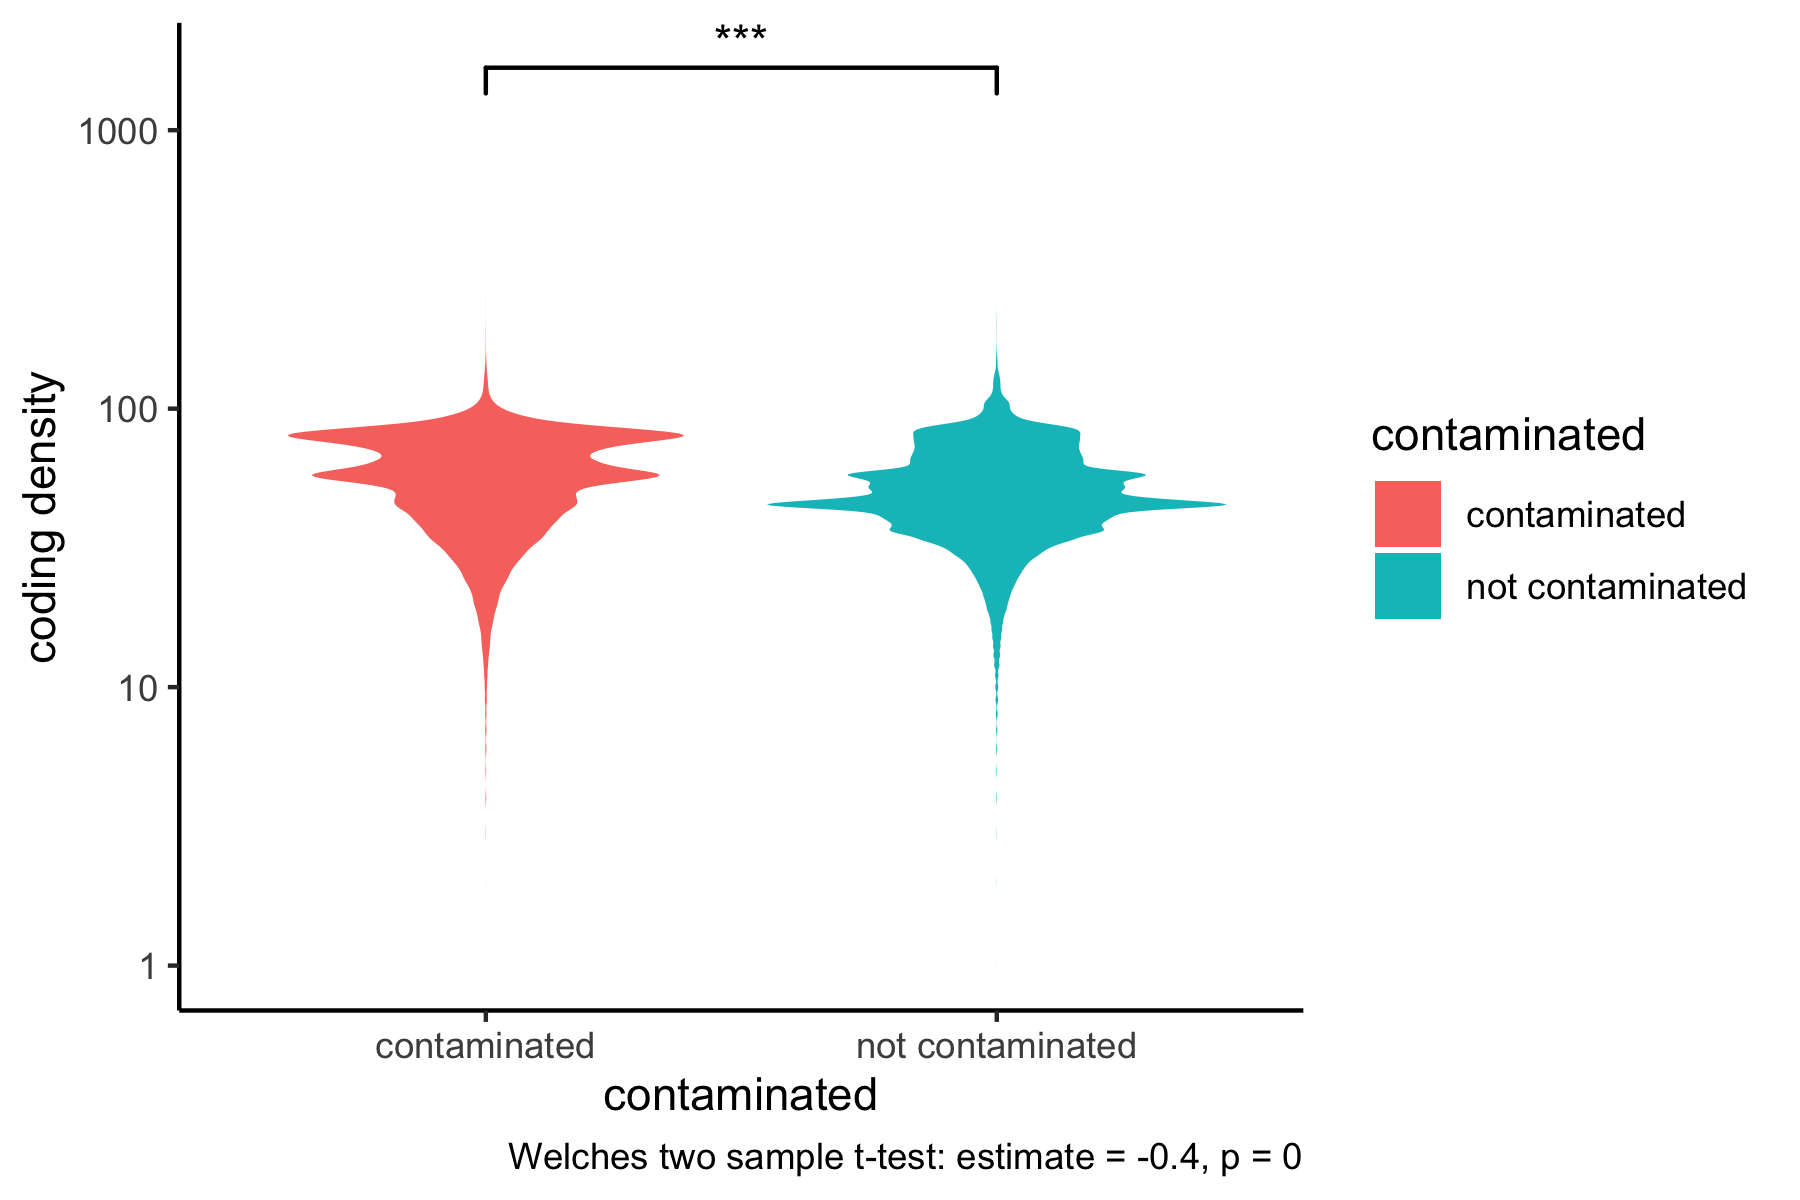

In [23]:
ttest_coding_density <- combined %>%
  do(tidy(t.test(coding_density ~ contaminated_at_filter_rank, data = .)))

coding_density_contam_plt <- ggplot(combined, aes(x = contaminated_at_filter_rank, y = trna_count, 
                     fill = contaminated_at_filter_rank)) +
  #geom_boxplot(outlier.alpha = .05) +
  geom_violin(color = NA) +
  theme_classic() +
  scale_y_log10() +
  geom_signif(comparisons = list(c('TRUE', 'FALSE')), map_signif_level=TRUE) +
  labs(x = "contaminated", y = "coding density", fill = "contaminated",
       caption = paste0("Welches two sample t-test: estimate = ", 
                        round(ttest_coding_density$estimate, digits = 1), 
                        ", p = ", round(ttest_coding_density$p.value, digits = 3))) +
  scale_x_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) +
  scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated"))

coding_density_contam_plt

In [24]:
combined %>%
  group_by(contaminated_at_filter_rank) %>%
  summarize(mean_of_coding_density = mean(coding_density))

contaminated_at_filter_rank,mean_of_coding_density
<fct>,<dbl>
TRUE,87.82038
FALSE,88.20368


## Contamination in single cell genomes or metagenome-assembled genomes

In [25]:
table(combined$ncbi_genome_category)


derived from environmental sample           derived from metagenome 
                             7465                             77891 
         derived from single cell                              none 
                              831                            231354 

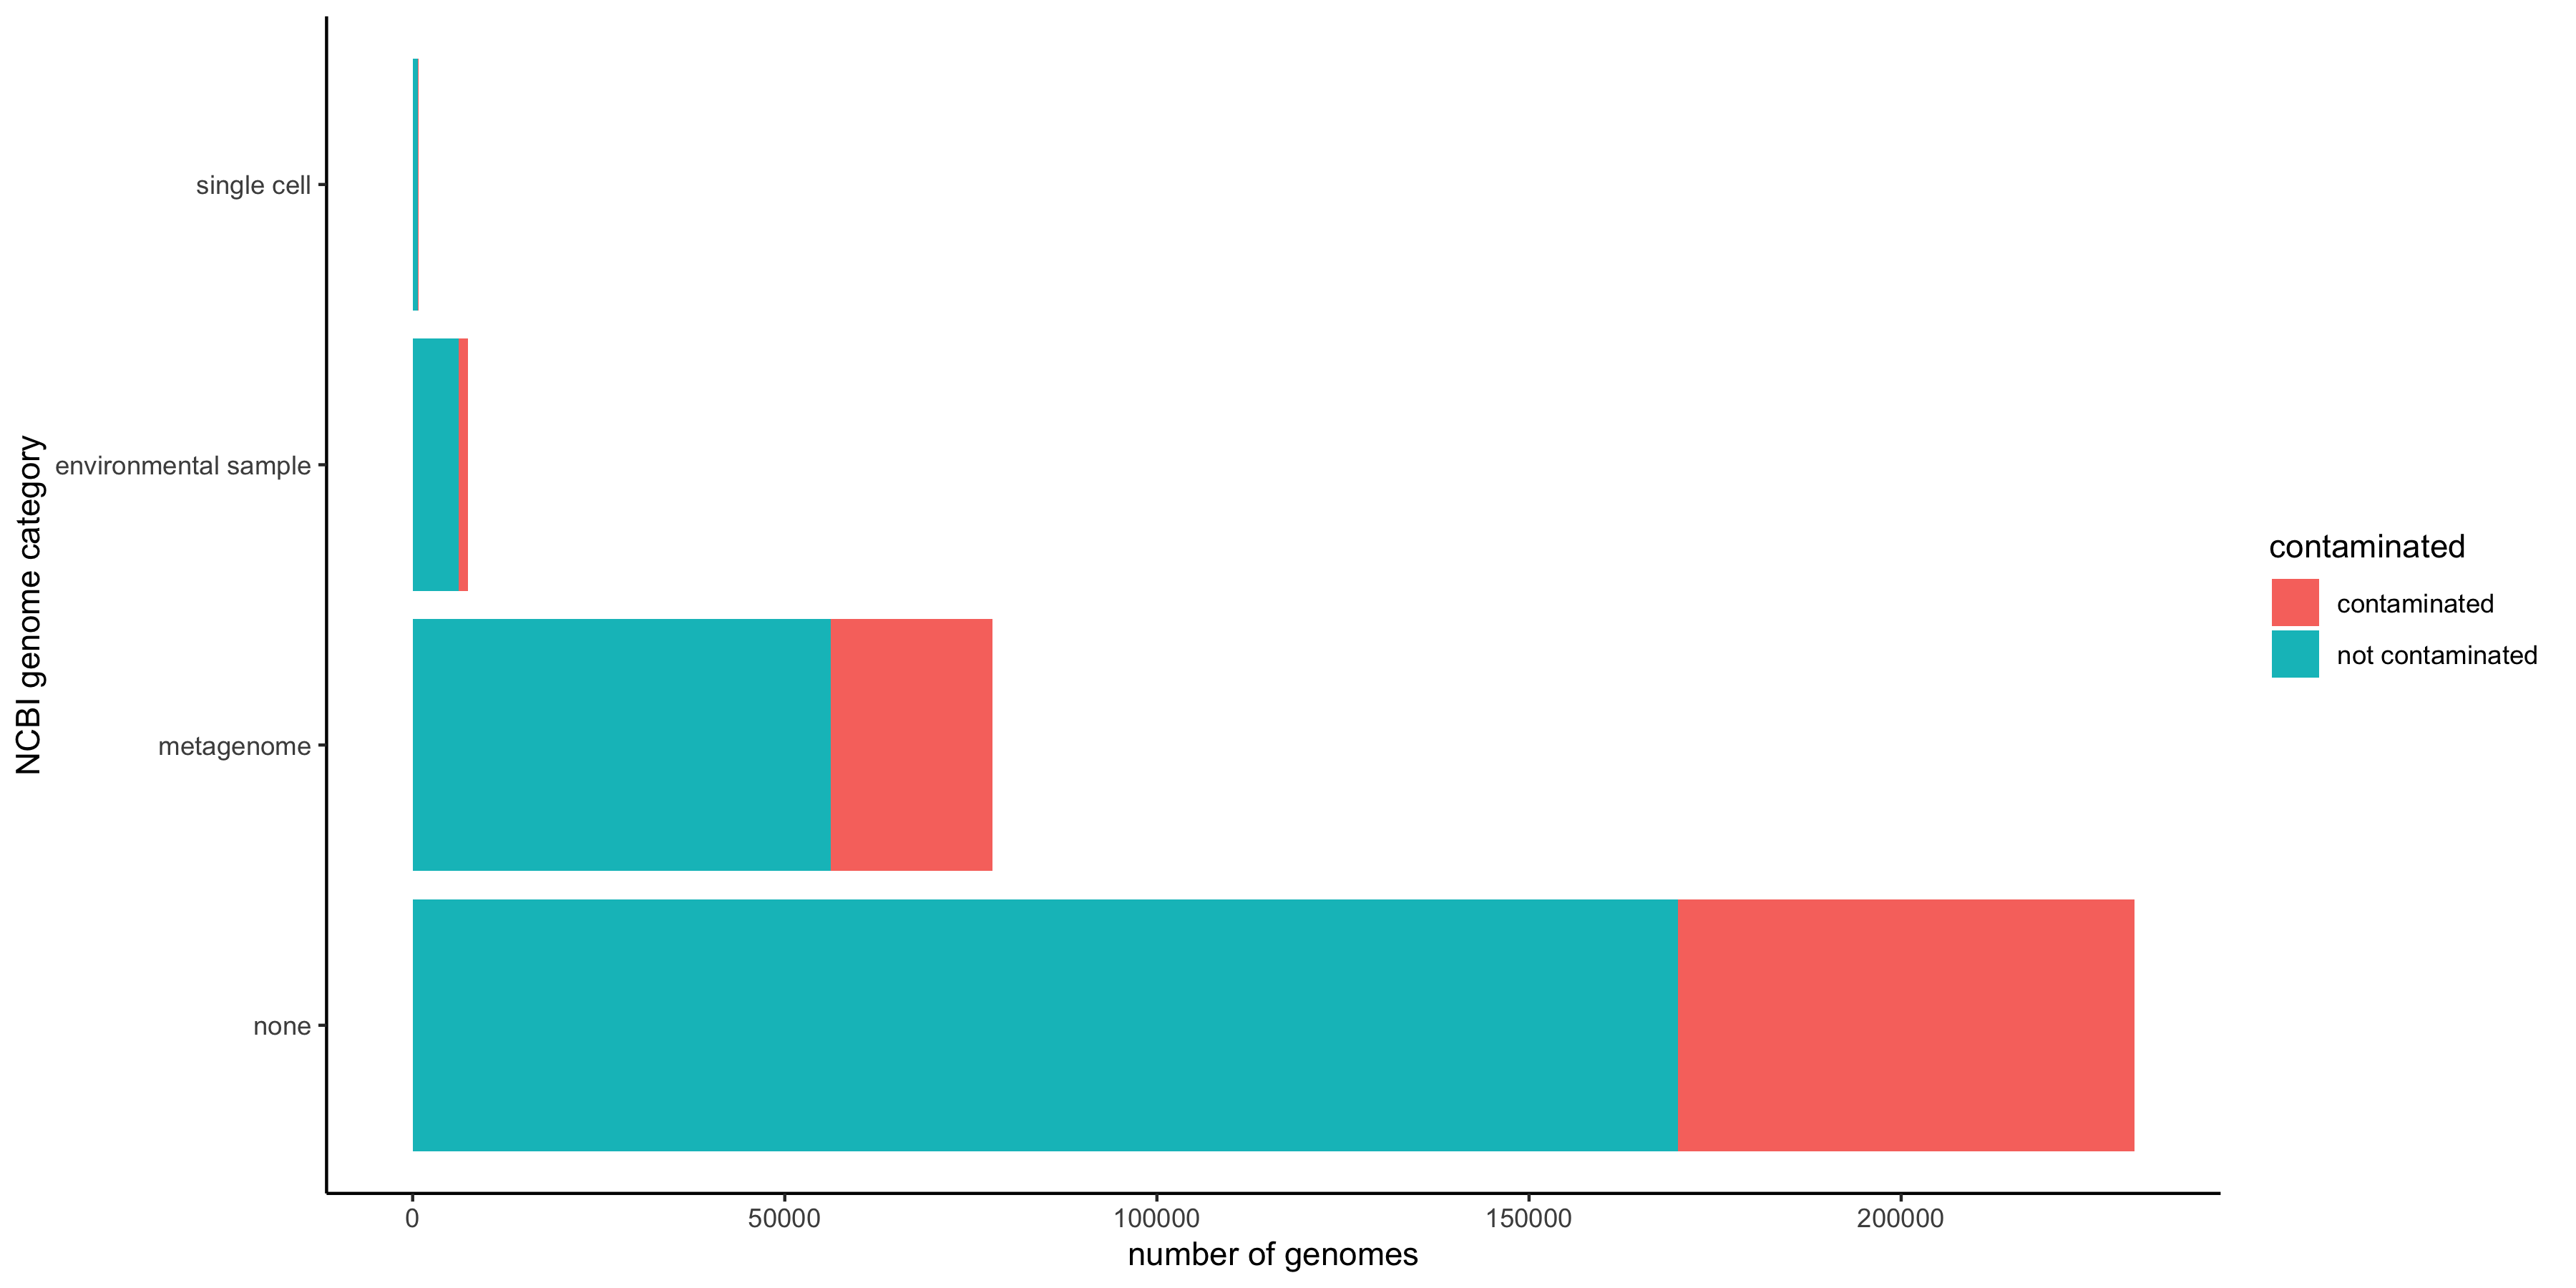

In [39]:
combined <- combined %>%
  mutate(ncbi_genome_category2 = gsub("derived from ", "", ncbi_genome_category),
         ncbi_genome_category2 = factor(ncbi_genome_category2,
                                       levels = c("none", "metagenome", 
                                                  "environmental sample", "single cell")))

num_contam_cat_plt <- ggplot(combined, aes(x = ncbi_genome_category2, label = stat(count), fill = contaminated_at_filter_rank)) +
  geom_bar() +
  #geom_text(stat = 'count', vjust = 2, color = "lightgrey") +
  #geom_text(stat = 'count', hjust = 1.5, color = "white", position = "stack") +
  theme_classic() +
  labs(y = "number of genomes", x = "NCBI genome category", fill = "contaminated") +
  scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) +
  coord_flip()
         
num_contam_cat_plt

## percent of genomes within an order that are contaminated

There are 1330 order-level lineages. 
Using percentages/fractions to account for differences in order sizes, is one order more likely to have contaminated genomes than other orders?

In [27]:
length(unique(combined$order_lineage))

[1] 1593

In [28]:
num_genomes_per_order <- combined %>%
  group_by(order_lineage) %>%
  tally() %>%
  select(order_lineage, num_genomes_in_order = n)

num_genomes_contaminated_per_order <- combined %>%
  group_by(order_lineage, contaminated_at_filter_rank) %>%
  tally() %>%
  filter(contaminated_at_filter_rank == TRUE) %>%
  select(order_lineage, num_genomes_contaminated = n) %>%
  left_join(num_genomes_per_order, by = "order_lineage") %>%
  mutate(frac_contaminated_in_order = num_genomes_contaminated/num_genomes_in_order,
         num_genomes_not_contaminated = num_genomes_in_order - num_genomes_contaminated)

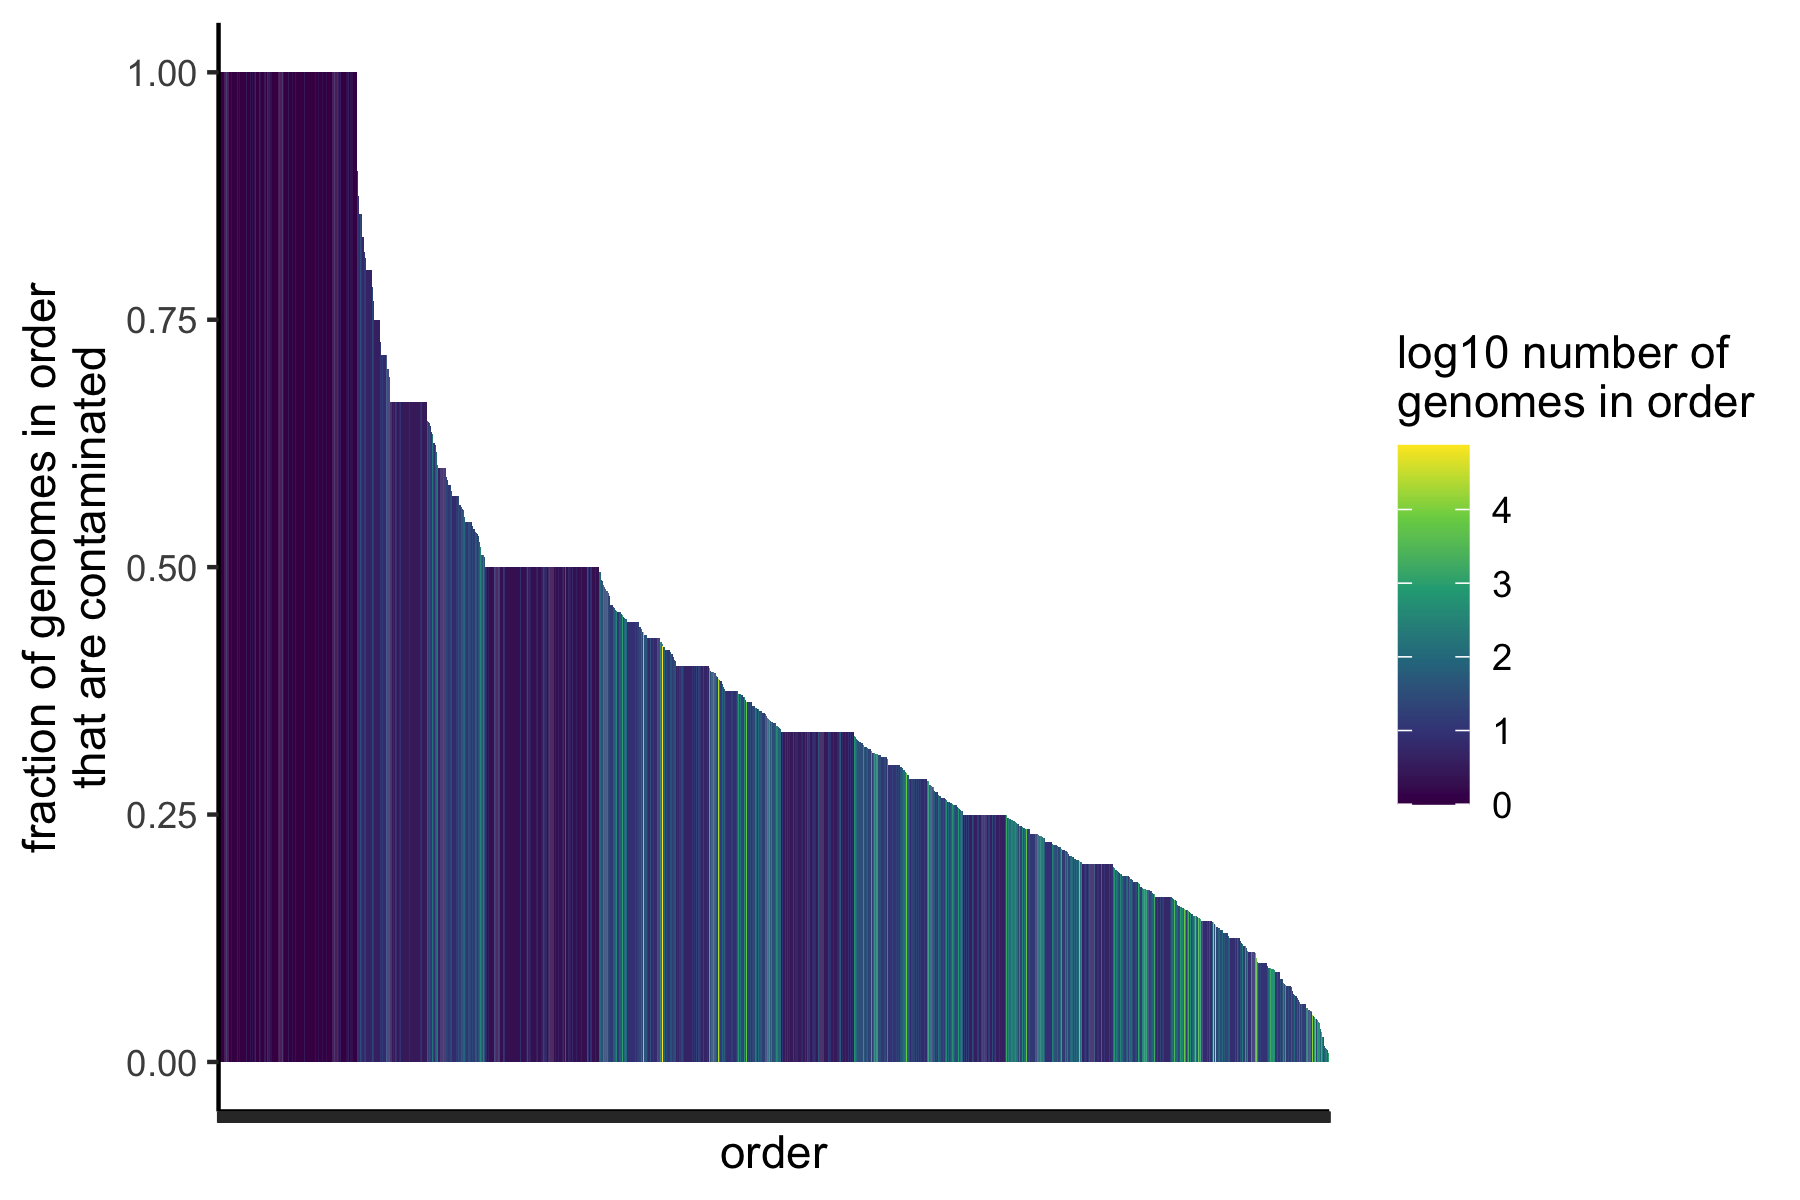

In [29]:
ggplot(num_genomes_contaminated_per_order, aes(x = reorder(order_lineage, -frac_contaminated_in_order), 
                                               y = frac_contaminated_in_order, 
                                               fill = log10(num_genomes_in_order))) +
  geom_col() +
  theme_classic() +
  theme(axis.text.x = element_blank()) +
  scale_fill_viridis_c() +
  labs(y = "fraction of genomes in order\nthat are contaminated", x = "order", fill = "log10 number of\ngenomes in order")

In [30]:
tmp <- num_genomes_contaminated_per_order %>%
  select(-num_genomes_in_order, -frac_contaminated_in_order) %>%
  pivot_longer(cols = -order_lineage, names_to = "contamination", values_to = "num_genomes") %>%
  left_join(num_genomes_per_order, by = "order_lineage")

In [31]:
head(tmp)

order_lineage,contamination,num_genomes,num_genomes_in_order
<chr>,<chr>,<int>,<int>
d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarchaeia;o__Aenigmatarchaeales,num_genomes_contaminated,3,18
d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarchaeia;o__Aenigmatarchaeales,num_genomes_not_contaminated,15,18
d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarchaeia;o__CG10238-14,num_genomes_contaminated,3,36
d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarchaeia;o__CG10238-14,num_genomes_not_contaminated,33,36
d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarchaeia;o__GW2011-AR5,num_genomes_contaminated,2,29
d__Archaea;p__Aenigmatarchaeota;c__Aenigmatarchaeia;o__GW2011-AR5,num_genomes_not_contaminated,27,29


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 141 rows containing missing values (geom_col).”


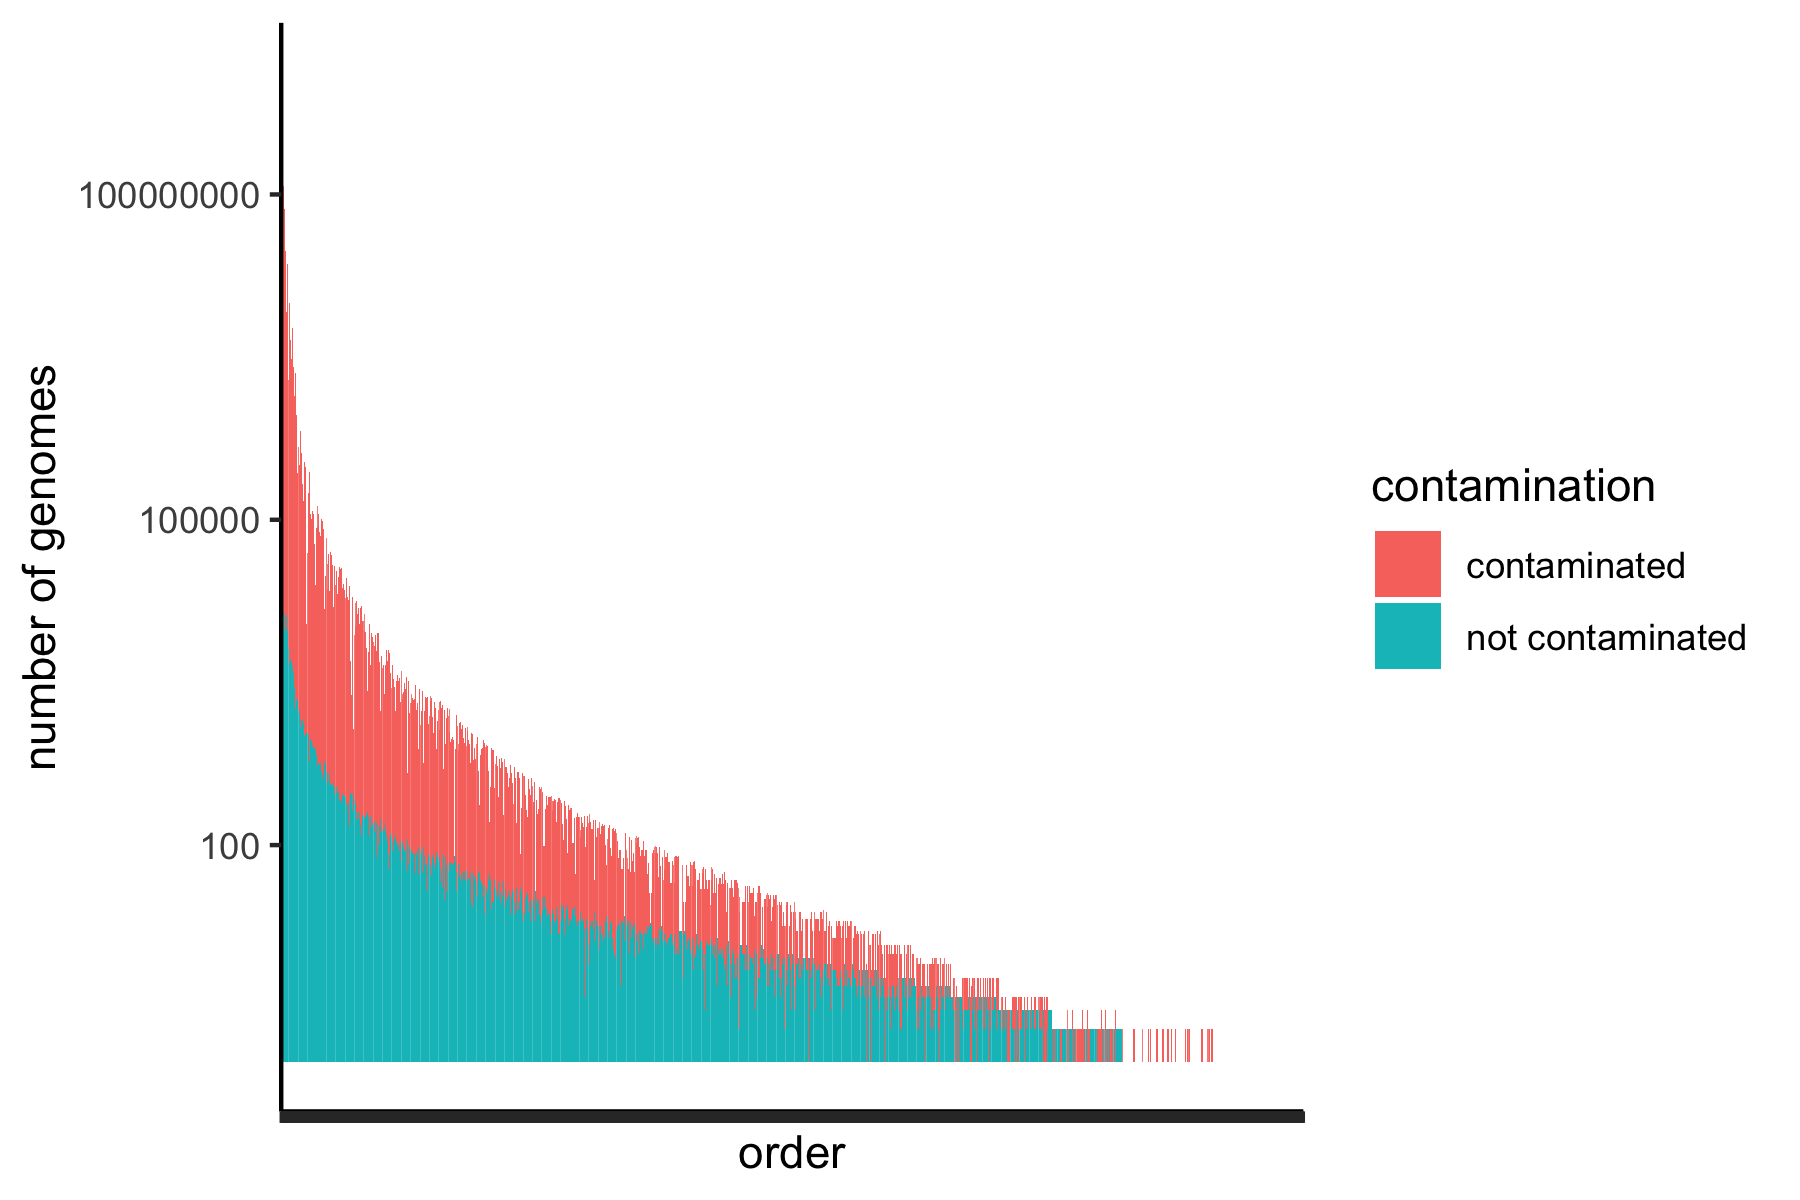

In [32]:
contam_by_order_plt <- ggplot(tmp, aes(x = reorder(order_lineage, -num_genomes_in_order), 
                y = num_genomes, 
                fill = contamination)) +
  geom_col() +
  theme_classic() +
  theme(axis.text.x = element_blank()) +
  scale_y_log10() +
  labs(x = "order", y = "number of genomes") +
  scale_fill_discrete(labels = c("num_genomes_contaminated" = "contaminated", 
                                 "num_genomes_not_contaminated" = "not contaminated"))

contam_by_order_plt

In [33]:
colnames(combined)

[1] "genome"                            "filter_at"                        
  [3] "override_filter_at"                "total_bad_bp"                     
  [5] "superkingdom_bad_bp"               "phylum_bad_bp"                    
  [7] "class_bad_bp"                      "order_bad_bp"                     
  [9] "family_bad_bp"                     "genus_bad_bp"                     
 [11] "f_ident"                           "f_major"                          
 [13] "lineage"                           "comment"                          
 [15] "ambiguous_bases"                   "checkm_completeness"              
 [17] "checkm_contamination"              "checkm_marker_count"              
 [19] "checkm_marker_lineage"             "checkm_marker_set_count"          
 [21] "checkm_strain_heterogeneity"       "coding_bases"                     
 [23] "coding_density"                    "contig_count"                     
 [25] "gc_count"                          "gc_percentage"                    
 [27] "genome_size"                       "gtdb_genome_representative"       
 [29] "gtdb_representative"               "domain"                           
 [31] "phylum"                            "class"                            
 [33] "order"                             "family"                           
 [35] "genus"                             "species"                          
 [37] "gtdb_type_designation"             "gtdb_type_designation_sources"    
 [39] "gtdb_type_species_of_genus"        "l50_contigs"                      
 [41] "l50_scaffolds"                     "longest_contig"                   
 [43] "longest_scaffold"                  "lsu_23s_contig_len"               
 [45] "lsu_23s_count"                     "lsu_23s_length"                   
 [47] "lsu_23s_query_id"                  "lsu_5s_contig_len"                
 [49] "lsu_5s_count"                      "lsu_5s_length"                    
 [51] "lsu_5s_query_id"                   "lsu_silva_23s_blast_align_len"    
 [53] "lsu_silva_23s_blast_bitscore"      "lsu_silva_23s_blast_evalue"       
 [55] "lsu_silva_23s_blast_perc_identity" "lsu_silva_23s_blast_subject_id"   
 [57] "lsu_silva_23s_taxonomy"            "mean_contig_length"               
 [59] "mean_scaffold_length"              "mimag_high_quality"               
 [61] "mimag_low_quality"                 "mimag_medium_quality"             
 [63] "n50_contigs"                       "n50_scaffolds"                    
 [65] "ncbi_assembly_level"               "ncbi_assembly_name"               
 [67] "ncbi_assembly_type"                "ncbi_bioproject"                  
 [69] "ncbi_biosample"                    "ncbi_contig_count"                
 [71] "ncbi_contig_n50"                   "ncbi_country"                     
 [73] "ncbi_date"                         "ncbi_genbank_assembly_accession"  
 [75] "ncbi_genome_category"              "ncbi_genome_representation"       
 [77] "ncbi_isolate"                      "ncbi_isolation_source"            
 [79] "ncbi_lat_lon"                      "ncbi_molecule_count"              
 [81] "ncbi_ncrna_count"                  "ncbi_organism_name"               
 [83] "ncbi_protein_count"                "ncbi_refseq_category"             
 [85] "ncbi_rrna_count"                   "ncbi_scaffold_count"              
 [87] "ncbi_scaffold_l50"                 "ncbi_scaffold_n50"                
 [89] "ncbi_scaffold_n75"                 "ncbi_scaffold_n90"                
 [91] "ncbi_seq_rel_date"                 "ncbi_spanned_gaps"                
 [93] "ncbi_species_taxid"                "ncbi_ssu_count"                   
 [95] "ncbi_strain_identifiers"           "ncbi_submitter"                   
 [97] "ncbi_taxid"                        "ncbi_taxonomy"                    
 [99] "ncbi_taxonomy_unfiltered"          "ncbi_total_gap_length"            
[101] "ncbi_total_length"                 "ncbi_translation_table"           
[103] "ncbi_trna_count" 

In [34]:
print("superkingdom")
table(combined$superkingdom_bad_bp > 0)
print("phylum")
table(combined$phylum_bad_bp > 0)
print("class")
table(combined$class_bad_bp > 0)
print("order")
table(combined$order_bad_bp > 0)
table(combined$family_bad_bp > 0)
table(combined$genus_bad_bp > 0)

[1] "superkingdom"



 FALSE   TRUE 
315918   1623 

[1] "phylum"



 FALSE   TRUE 
261803  55738 

[1] "class"



 FALSE   TRUE 
255656  61885 

[1] "order"



 FALSE   TRUE 
233149  84392 


 FALSE   TRUE 
 10173 307368 


 FALSE   TRUE 
 10173 307368 

## Combine plots

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 141 rows containing missing values (geom_col).”


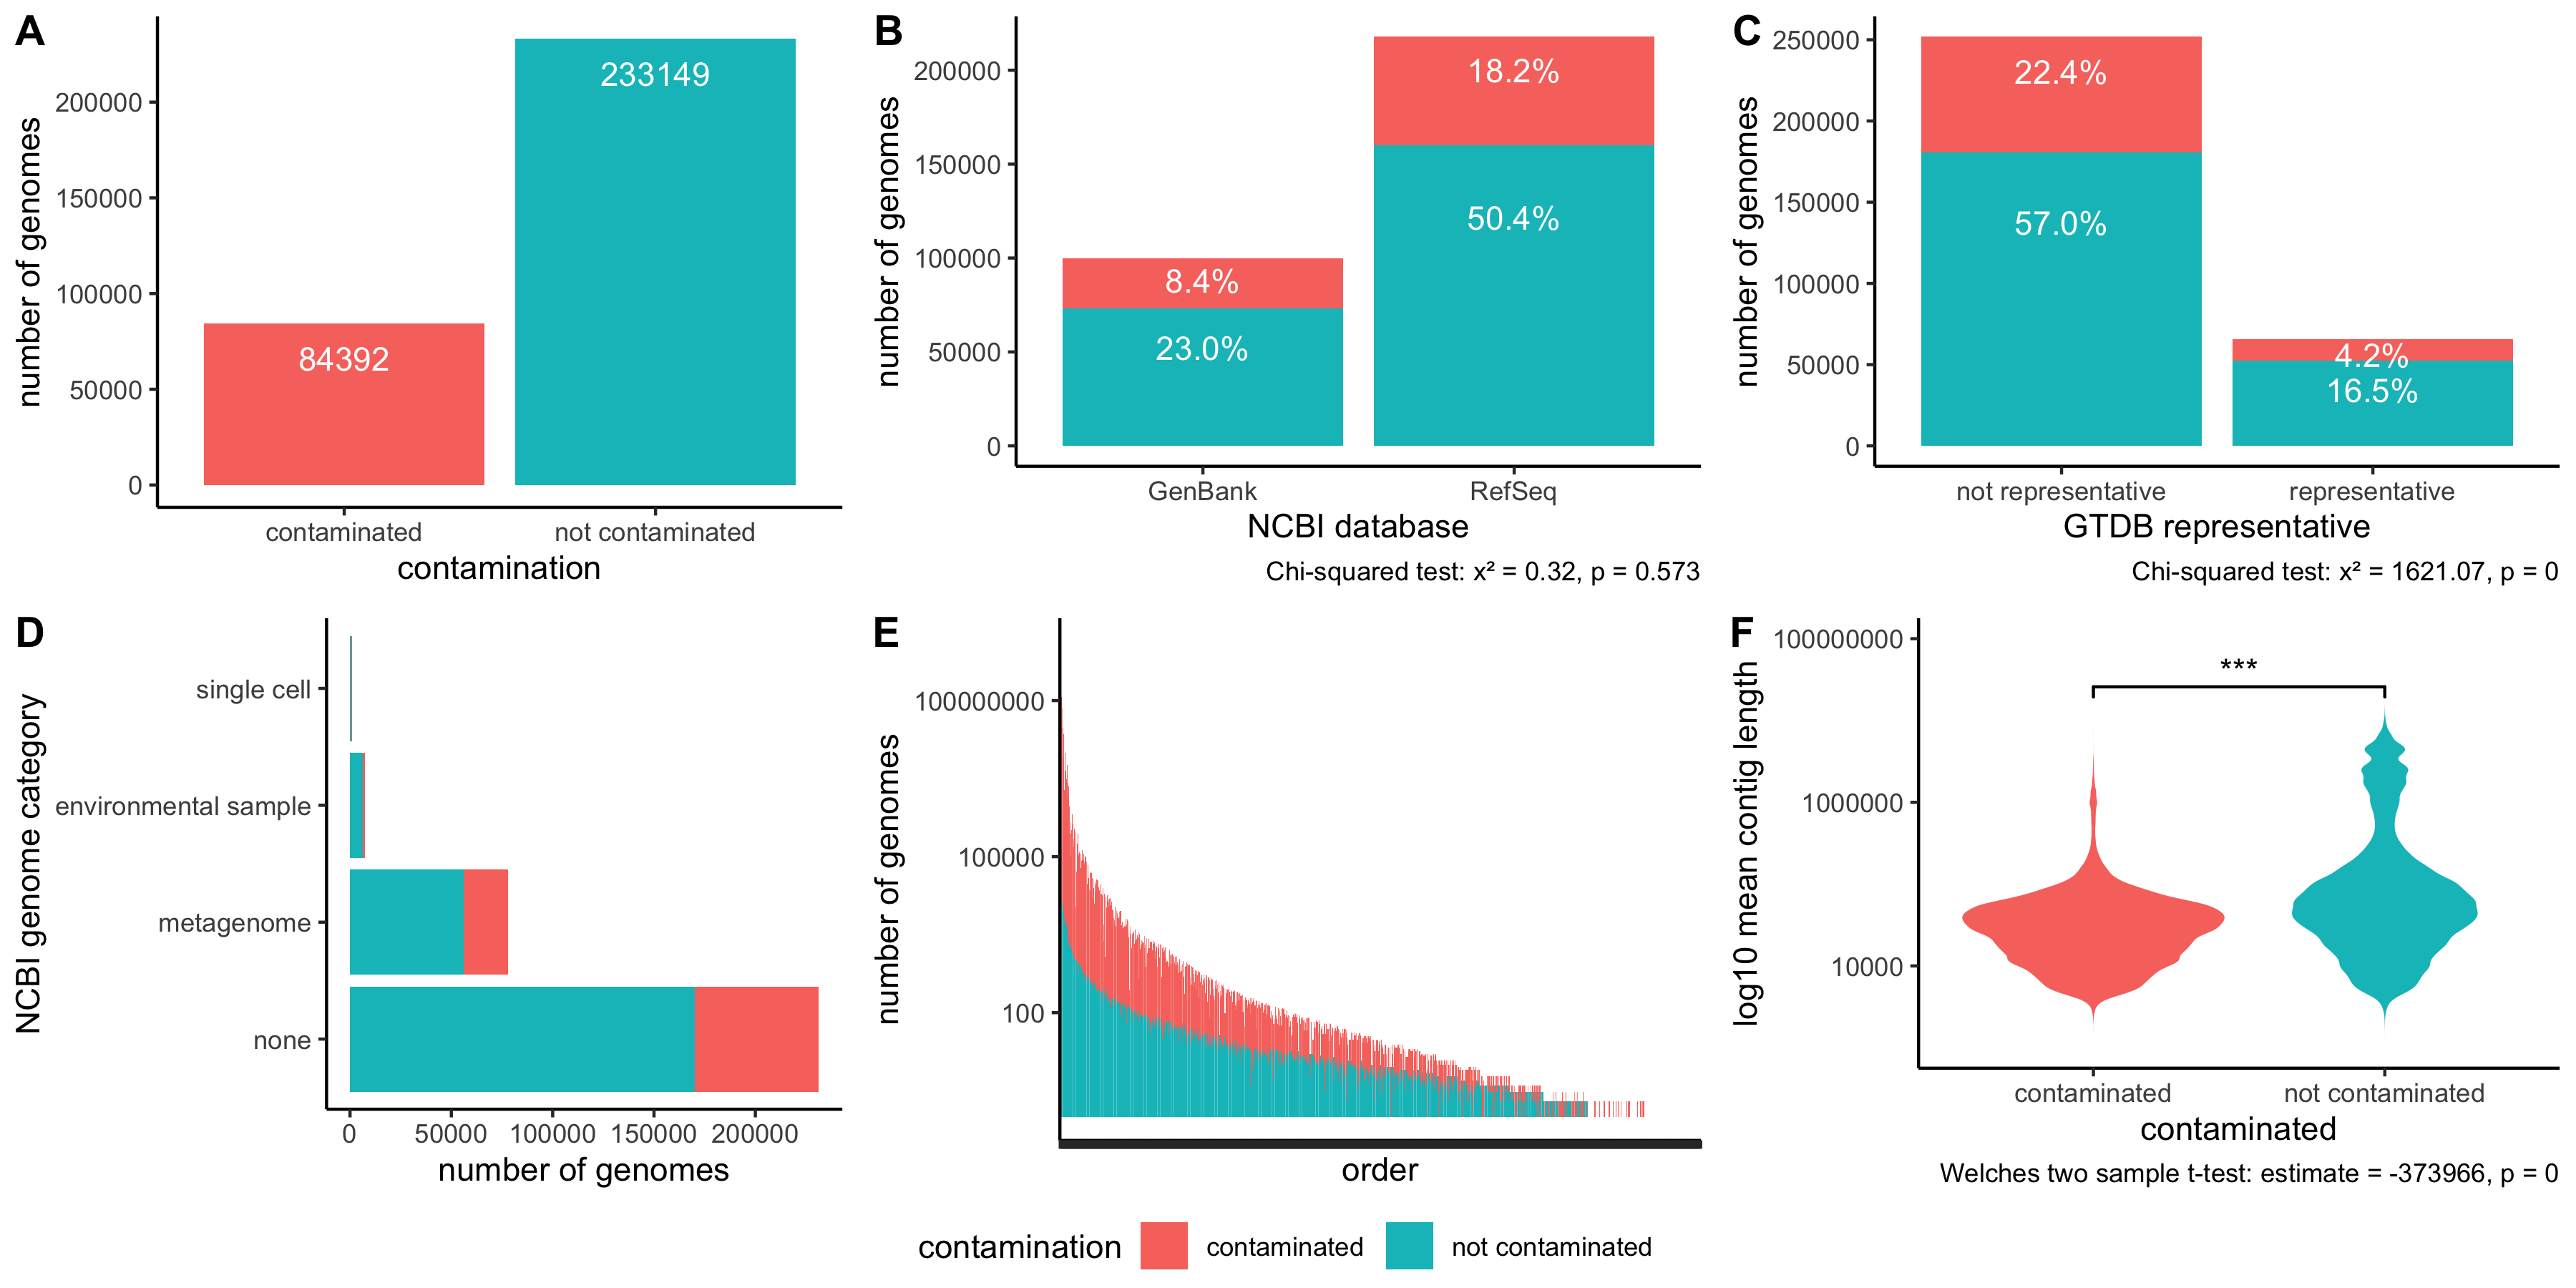

In [40]:
# change default figure size
options(repr.plot.width=12, repr.plot.height=6, repr.plot.res = 300)

ggarrange(ncol = 3, nrow = 2, common.legend = T, legend = "bottom", labels = c("A", "B", "C", "D", "E", "F"),
          num_contam_plt, num_contam_db_plt2, num_contam_reps_plt2,
          num_contam_cat_plt, contam_by_order_plt, len_contigs_contam_plt)

# if on same system as 2022-paper-charcoal
#png("../2022-paper-charcoal/content/images/charcoal_gtdb.png", res = 300, height = 6, width = 12, units = "in")
#ggarrange(ncol = 3, nrow = 2, common.legend = T, legend = "bottom", labels = c("A", "B", "C", "D", "E", "F"),
#          num_contam_plt, num_contam_db_plt2, num_contam_reps_plt2,
#          num_contam_cat_plt, contam_by_order_plt, len_contigs_contam_plt)
#dev.off()

In [36]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS/LAPACK: /Users/tr/miniconda3/envs/sandbox/lib/libopenblasp-r0.3.18.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggpubr_0.4.0  ggplot2_3.3.5 broom_0.7.12  purrr_0.3.4   tidyr_1.2.0  
[6] readr_2.1.2   dplyr_1.0.8  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-7       tidyselect_1.1.2   repr_1.1.4         carData_3.0-5     
 [5] colorspace_2.0-3   vctrs_0.3.8        generics_0.1.2     viridisLite_0.4.0 
 [9] htmltools_0.5.2    base64enc_0.1-3    utf8_1.2.2         rlang_1.0.2       
[13] pillar_1.7.0       glue_1.6.2         withr_2.5.0        DBI_1.1.2         
[17] bit64_4.0.5        RColorBrewer_1.1-2 uuid_1.0-4         lifecycle_1.0.1   
[21] munsell_0.5.0      ggsignif